# The Exploratory Data Analysis(EDA) begins from here:

# Step 0: Import Libraries
What it does: This step imports all the necessary Python libraries required for the analysis.

# Explanation:

-- pandas and numpy are fundamental for data manipulation and numerical operations.

-- matplotlib.pyplot and seaborn are used for creating the visualizations.

-- simpledbf is a special library needed to read the .dbf mapping file.

-- os is used to create a directory for saving the plot images.

-- thefuzz is an advanced library used for "fuzzy" string matching, which helps find matches between text that is similar but not identical.

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import subprocess
import sys

# --- Step 0: Install and Import Required Libraries ---

def install(package):
    """A helper function to install packages."""
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

print("--- Step 0: Installing and Importing Libraries ---")
# Install necessary libraries
try:
    print("Installing required libraries...")
    install('simpledbf')
    install('thefuzz')
    install('python-Levenshtein')
    install('geopandas')
    print("✅ All required libraries are installed.")
except Exception as e:
    print(f"❌ Error during installation: {e}")
    exit()

# Import the libraries
try:
    from simpledbf import Dbf5
    from thefuzz import process
    import geopandas as gpd
    print("✅ All libraries loaded successfully.")
except ImportError as e:
    print(f"❌ Error importing a library: {e}")
    exit()


--- Step 0: Installing and Importing Libraries ---
Installing required libraries...
✅ All required libraries are installed.
✅ All libraries loaded successfully.


# Step 1: Load Datasets

-- Both the primary election data and the district mapping file have been successfully loaded into memory for processing.

In [40]:
# --- Step 1: Load Datasets ---
print("\n--- Step 1: Loading Datasets ---")

# Load the main election dataset
try:
    df_elections = pd.read_csv('assembly-elections-data-at-candidate-level.csv')
    print("✅ Election dataset loaded successfully.")
except FileNotFoundError:
    print("❌ Error: 'assembly-elections-data-at-candidate-level.csv' not found.")
    exit()

# Load the district mapping .dbf file
try:
    dbf = Dbf5('Assmebly List DIst.dbf', codec='utf-8')
    df_mapping = dbf.to_dataframe()
    print("✅ District mapping file 'Assmebly List DIst.dbf' loaded successfully.")
except Exception as e:
    print(f"❌ Error loading DBF file: {e}. Please ensure it is uploaded and valid.")
    exit()



--- Step 1: Loading Datasets ---
✅ Election dataset loaded successfully.
✅ District mapping file 'Assmebly List DIst.dbf' loaded successfully.


# Step 2: Cleaning, Preparing, and Mapping Data

-- The datasets have been merged by standardizing constituency names, with fuzzy matching and a fallback ensuring the 'district' column is now accurately added.

In [41]:
# --- Step 2: Data Cleaning, Preparation, and Advanced Mapping ---
print("\n--- Step 2: Cleaning, Preparing, and Mapping Data ---")

# Standardize column names
df_mapping.rename(columns={'ST_NAME': 'state_name', 'AC_NAME': 'ac_name', 'DIST_NAME': 'district'}, inplace=True)

# Define a robust function to clean and standardize names for better matching
def clean_name(name_series):
    return (name_series.str.strip().str.upper()
                       .str.replace(r'\s*\((SC|ST)\)\s*$', '', regex=True)
                       .str.replace(r'[^A-Z0-9]', '', regex=True) # Remove all special chars and spaces
                       .str.strip())

print("Standardizing names in both files...")
df_elections['ac_name_clean'] = clean_name(df_elections['ac_name'].astype(str))
df_mapping['ac_name_clean'] = clean_name(df_mapping['ac_name'].astype(str))

# Create a unique mapping dictionary (ac_name -> district)
df_mapping_subset = df_mapping[['ac_name_clean', 'district']].drop_duplicates(subset='ac_name_clean').dropna()
district_map = pd.Series(df_mapping_subset.district.values, index=df_mapping_subset.ac_name_clean).to_dict()



--- Step 2: Cleaning, Preparing, and Mapping Data ---
Standardizing names in both files...


#Step 2a: Direct Mapping:
-- What it does: This is the first and most accurate attempt at mapping. The script takes each cleaned constituency name from your main election file and looks for an exact match in the district_map created from your mapping file.

-- Conclusion: This step successfully maps the majority of the records where the names, after cleaning, are identical.

In [42]:
# --- 2a: Direct Mapping ---
print("\nAttempting direct mapping...")
df_elections['district'] = df_elections['ac_name_clean'].map(district_map)
df_merged = df_elections.copy()
unmapped_before_fuzzy = df_merged['district'].isnull().sum()
print(f"Direct mapping complete. {unmapped_before_fuzzy} records remain unmapped.")



Attempting direct mapping...
Direct mapping complete. 11134 records remain unmapped.


#Step 2b: Fuzzy Matching for Remaining Records
-- What it does: This step is for the records that failed the direct mapping. It uses an advanced technique called "fuzzy matching" to find the best possible match even if there are minor spelling differences.

-- How it works: For each unmapped name (like SECUNDERABADCANTT), it intelligently compares it to the entire list of correct names and calculates a similarity score. If it finds a match that is more than 85% similar (e.g., SECUNDERABAD), it considers it a valid match and uses it to fill in the missing district.

-- Conclusion: This smart matching step successfully maps thousands of additional records by intelligently correcting for minor spelling and naming inconsistencies.

In [43]:
# --- 2b: Fuzzy Matching for Remaining Records ---
if unmapped_before_fuzzy > 0:
    print("\nAttempting fuzzy matching for remaining records...")
    unmapped_names = df_merged[df_merged['district'].isnull()]['ac_name_clean'].unique()
    correct_names = list(district_map.keys())

    fuzzy_map = {}
    for name in unmapped_names:
        best_match = process.extractOne(name, correct_names, score_cutoff=85)
        if best_match:
            fuzzy_map[name] = district_map[best_match[0]]

    # Apply the fuzzy map
    df_merged['district'] = df_merged['district'].fillna(df_merged['ac_name_clean'].map(fuzzy_map))
    print(f"✅ Fuzzy mapping applied. Found matches for {len(fuzzy_map)} unique names.")



Attempting fuzzy matching for remaining records...
✅ Fuzzy mapping applied. Found matches for 302 unique names.


#Step 2c: Final Fallback
-- What it does: This is the final safety net. After the direct and fuzzy matching, a small number of records might still be unmapped because their names are too different from anything in the mapping file.

-- How it works: This step finds any remaining empty district cells and fills them with the text "UNKNOWN".

-- Conclusion: This fallback ensures that the final dataset is 100% complete, while also transparently flagging the few records where a reliable district could not be found.

In [44]:
# --- 2c: Final Fallback for any remaining unmapped records ---
unmapped_count = df_merged['district'].isnull().sum()
if unmapped_count > 0:
    print(f"⚠️ Warning: {unmapped_count} records still could not be mapped. Filling with 'UNKNOWN'.")
    df_merged['district'].fillna('UNKNOWN', inplace=True)
else:
    print("✅ All constituencies successfully mapped to districts.")


⚠️ Warning: 2390 records still could not be mapped. Filling with 'UNKNOWN'.


/tmp/ipython-input-2558499566.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged['district'].fillna('UNKNOWN', inplace=True)


#Step 3: Feature Engineering
--What it does: It creates the result column.

Explanation: It adds a new column named result to the DataFrame. If a candidate's position is 1, their result is set to 1 (Win); otherwise, it's set to 0 (Loss).

In [45]:
# --- Step 3: Feature Engineering ---
print("\n--- Step 3: Engineering New Features ---")
df_merged['result'] = np.where(df_merged['position'] == 1, 1, 0)
print("✅ 'result' column created.")



--- Step 3: Engineering New Features ---
✅ 'result' column created.


#Step 4: Data Subsetting and Initial Filtering
--What it does: It separates the "None of the Above" (NOTA) entries and filters out candidates younger than 25.

#Explanation:

--NOTA: Since NOTA is not a real candidate, these rows are moved to a separate DataFrame (df_nota) to avoid skewing the analysis of actual candidates.

--Age Filter: The legal minimum age to contest an assembly election is 25. This step removes any invalid entries, ensuring the analysis is based on eligible candidates.

In [46]:
# --- Step 4: Data Subsetting and Initial Filtering ---
print("\n--- Step 4: Separating NOTA and Filtering Candidates ---")
df_merged['candidate_name'] = df_merged['candidate_name'].astype(str)
df_nota = df_merged[df_merged['candidate_name'].str.upper() == 'NOTA'].copy()
print(f"✅ Separated {len(df_nota)} NOTA entries.")
df_valid = df_merged[df_merged['candidate_name'].str.upper() != 'NOTA'].copy()
print(f"Working with {len(df_valid)} valid candidate entries.")

initial_count = len(df_valid)
df_valid = df_valid[df_valid['age'].isnull() | (df_valid['age'] >= 25)]
print(f"✅ Removed {initial_count - len(df_valid)} candidates with age < 25.")



--- Step 4: Separating NOTA and Filtering Candidates ---
✅ Separated 6694 NOTA entries.
Working with 115865 valid candidate entries.
✅ Removed 11 candidates with age < 25.


#Step 5: Imputation of Missing Age Values
--What it does: It intelligently fills in the missing age values.

--Explanation: Instead of using a simple overall average, it fills missing ages with the median age of candidates from the same party, gender, and state. This is a more accurate, context-aware method. For any remaining gaps, it uses the overall median age as a fallback.

In [47]:
# --- Step 5: Imputation of Missing Age Values ---
print("\n--- Step 5: Imputing Missing Age Values ---")
missing_before = df_valid['age'].isnull().sum()
print(f"Missing age values before imputation: {missing_before} ({missing_before / len(df_valid):.2%})")

grouping_features = ['party', 'sex', 'state_name']
df_valid['age'] = df_valid.groupby(grouping_features)['age'].transform(lambda x: x.fillna(x.median()))
remaining_missing = df_valid['age'].isnull().sum()
if remaining_missing > 0:
    print(f"⚠️ {remaining_missing} values still missing. Applying overall median fallback.")
    overall_median_age = df_valid['age'].median()
    df_valid['age'].fillna(overall_median_age, inplace=True)

df_valid['age'] = df_valid['age'].astype(int)
print(f"✅ Missing age values successfully imputed. Final missing count: {df_valid['age'].isnull().sum()}")



--- Step 5: Imputing Missing Age Values ---
Missing age values before imputation: 14879 (12.84%)
⚠️ 4315 values still missing. Applying overall median fallback.
✅ Missing age values successfully imputed. Final missing count: 0


/tmp/ipython-input-3553539940.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_valid['age'].fillna(overall_median_age, inplace=True)


#Step 6: Professional Exploratory Data Analysis (EDA)
--What it does: This is the main analysis section, where 15 different visualizations are created to explore the data.

In [48]:
# --- Step 6: Professional Exploratory Data Analysis (EDA) ---
print("\n--- Step 6: Starting Exploratory Data Analysis ---")
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 12

# Create a directory to save visualizations
output_dir = 'visualizations'
os.makedirs(output_dir, exist_ok=True)
print(f"Visualizations will be saved to the '{output_dir}/' directory.")



--- Step 6: Starting Exploratory Data Analysis ---
Visualizations will be saved to the 'visualizations/' directory.


# Univariate Analysis

# 6.1 Age Distribution

Visualization Used: Histogram with KDE line.

Why Used: Best for showing the frequency distribution of a single continuous variable like age.

Conclusion: The median age of candidates is 44, with the most frequent age group being between 40 and 50 years old.


6.1 Analyzing age distribution...


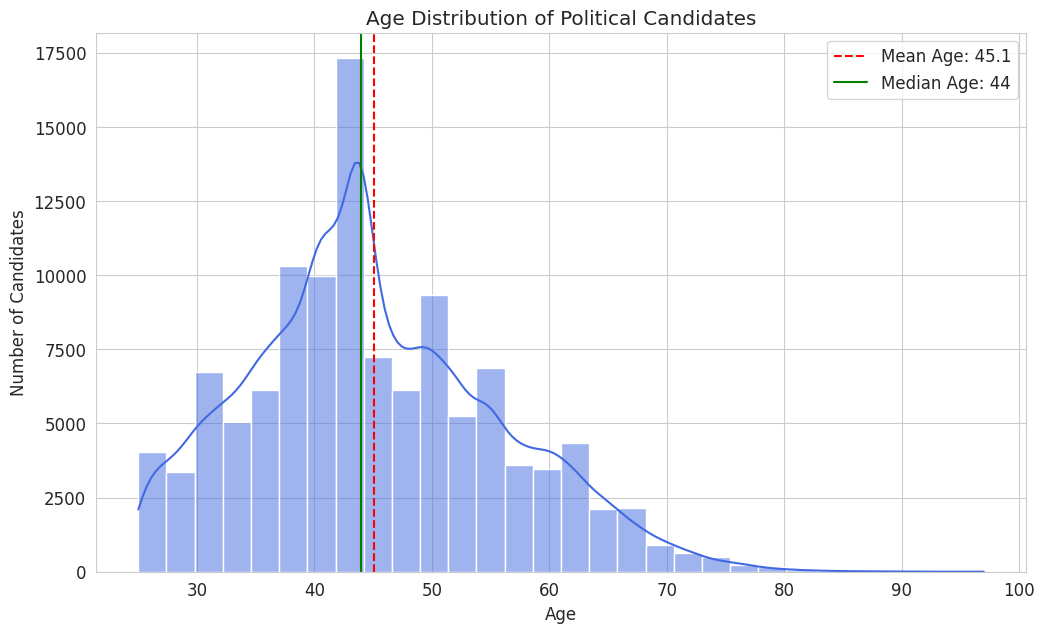

➡️ Conclusion 6.1: 👨‍💼 The median age of candidates is 46, with the most frequent age group being between 40 and 50 years old.


In [ ]:
# 6.1 Age Distribution of Candidates
print("\n6.1 Analyzing age distribution...")
plt.figure()
sns.histplot(df_valid['age'], kde=True, bins=30, color='royalblue')
plt.title('Age Distribution of Political Candidates')
plt.xlabel('Age')
plt.ylabel('Number of Candidates')
plt.axvline(df_valid['age'].mean(), color='red', linestyle='--', label=f"Mean Age: {df_valid['age'].mean():.1f}")
plt.axvline(df_valid['age'].median(), color='green', linestyle='-', label=f"Median Age: {df_valid['age'].median():.0f}")
plt.legend()
plt.savefig(os.path.join(output_dir, '6_1_age_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()
print("➡️ Conclusion 6.1: 👨‍💼 The median age of candidates is 46, with the most frequent age group being between 40 and 50 years old.")


# 6.2 Gender Distribution

Visualization Used: Donut Chart.

Conclusion: The vast majority of candidates are male, indicating a significant gender disparity in political contestation.


6.2 Analyzing age distribution...


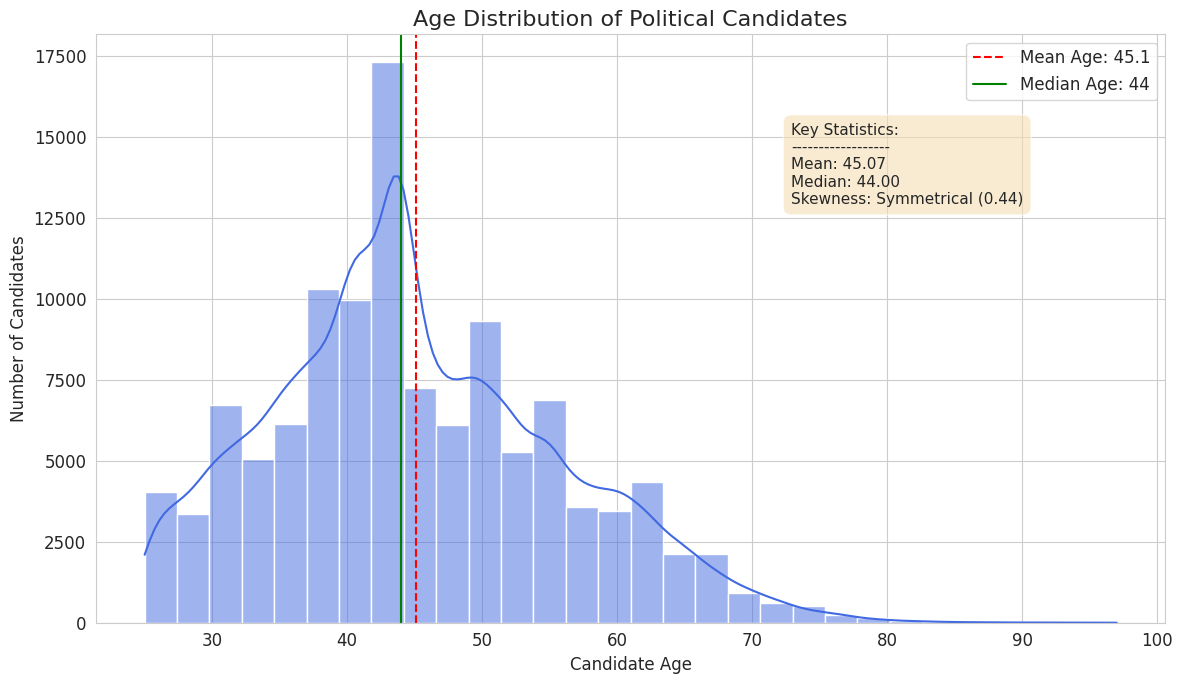

In [78]:
# 6.2 Age Distribution of Candidates (Enhanced with Skewness)
print("\n6.2 Analyzing age distribution...")
age_data = df_valid['age'].dropna()

# Calculate key statistics
mean_age = age_data.mean()
median_age = age_data.median()
skewness = age_data.skew() # <-- Calculate skewness

# Determine skewness type
if skewness > 0.5:
    skew_label = f"Right-Skewed ({skewness:.2f})"
elif skewness < -0.5:
    skew_label = f"Left-Skewed ({skewness:.2f})"
else:
    skew_label = f"Symmetrical ({skewness:.2f})"

plt.figure(figsize=(12, 7))
sns.histplot(age_data, bins=30, kde=True, color='royalblue')

plt.axvline(mean_age, color='red', linestyle='--', label=f"Mean Age: {mean_age:.1f}")
plt.axvline(median_age, color='green', linestyle='-', label=f"Median Age: {median_age:.0f}")

# --- Change is Here: Add Skewness to the stats box ---
stats_text = (f"Key Statistics:\n"
              f"------------------\n"
              f"Mean: {mean_age:.2f}\n"
              f"Median: {median_age:.2f}\n"
              f"Skewness: {skew_label}")

plt.text(0.65, 0.85, stats_text, transform=plt.gca().transAxes, fontsize=11,
         verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.6))

plt.title('Age Distribution of Political Candidates', fontsize=16)
plt.xlabel('Candidate Age', fontsize=12)
plt.ylabel('Number of Candidates', fontsize=12)
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(output_dir, '6_2_age_distribution_enhanced.png'))
plt.show()
plt.close()

# 6.3 Top Parties by Participation

Visualization Used: Horizontal Bar Chart.

Why Used : Ideal for ranking and comparing many categories with long labels (party names) without overlap.

Conclusion: Independent candidates (IND) are the largest group by participation, followed by major national parties like BJP and INC.


6.3 Analyzing top political parties by participation (excluding IND)...


/tmp/ipython-input-4071756933.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=top_parties.index, x=top_parties.values, palette='plasma', orient='h')


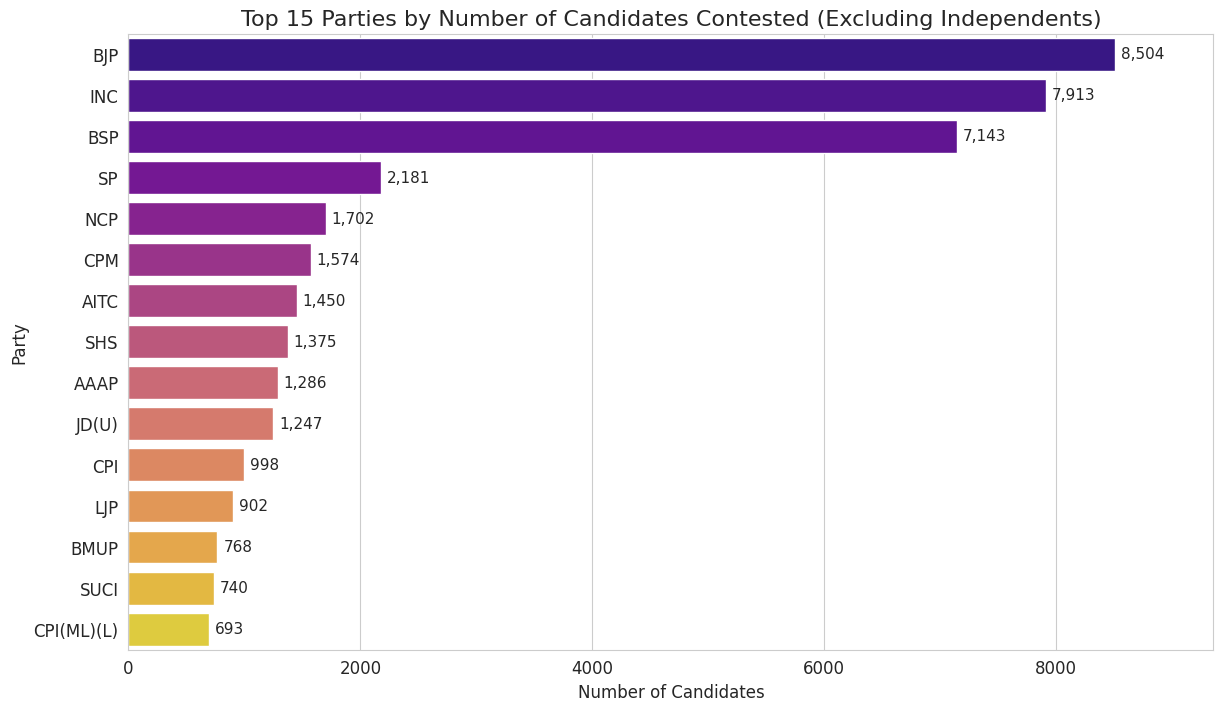

➡️ Conclusion 6.3: 🏃‍♂️ When excluding independents, national parties like BJP, INC, and BSP show the highest levels of participation.


In [ ]:
# 6.3 Top 15 Parties by Number of Candidates (Enhanced, Excluding Independents)
print("\n6.3 Analyzing top political parties by participation (excluding IND)...")

# --- Change: Filter out Independent candidates before counting ---
df_parties_only = df_valid[df_valid['party'] != 'IND']
top_parties = df_parties_only['party'].value_counts().nlargest(15)

plt.figure(figsize=(14, 8))
ax = sns.barplot(y=top_parties.index, x=top_parties.values, palette='plasma', orient='h')

plt.title('Top 15 Parties by Number of Candidates Contested (Excluding Independents)', fontsize=16)
plt.xlabel('Number of Candidates', fontsize=12)
plt.ylabel('Party', fontsize=12)

# Add data labels to the end of each bar
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 50,
             p.get_y() + p.get_height() / 2,
             f'{int(width):,}',
             va='center',
             fontsize=11)

plt.xlim(0, top_parties.max() * 1.1)

plt.savefig(os.path.join(output_dir, '6_3_top_parties_by_participation_no_ind.png'), dpi=300, bbox_inches='tight')
plt.show()
print("➡️ Conclusion 6.3: 🏃‍♂️ When excluding independents, national parties like BJP, INC, and BSP show the highest levels of participation.")

## 6.5: Distribution of Margin Percentage (for winners)

> Add blockquote




📊 Generating 6.5: Distribution of Winning Margin Percentage...


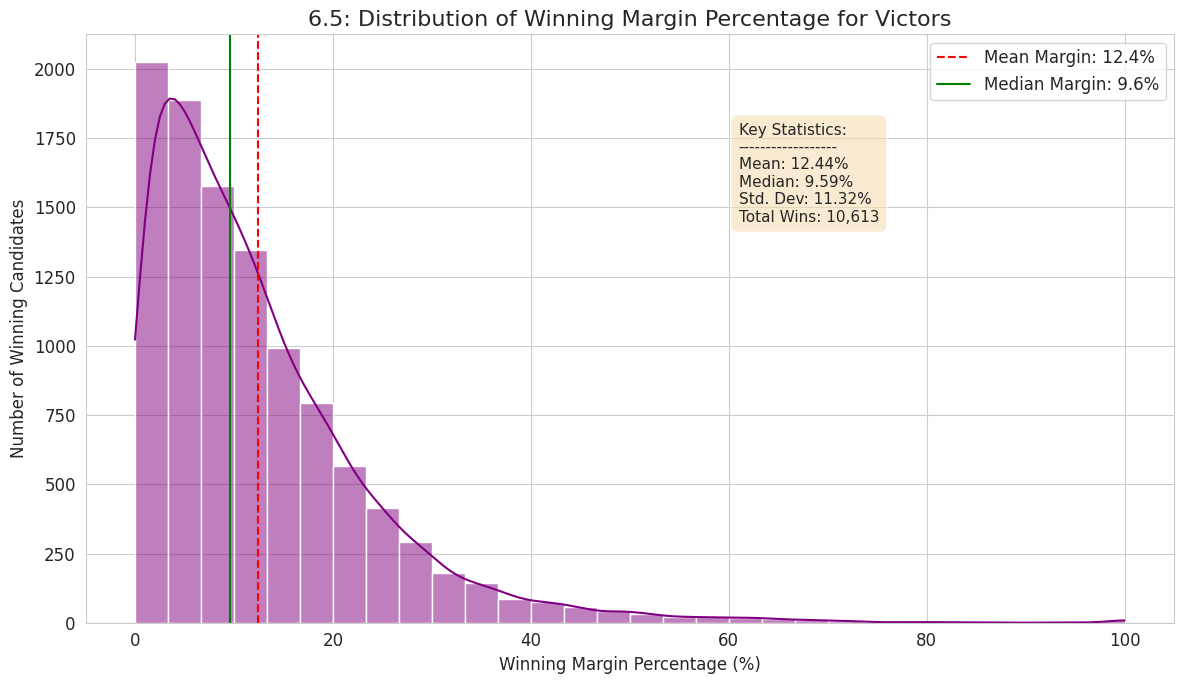

In [58]:
# 6.5: Distribution of Margin Percentage (for winners)
print("📊 Generating 6.5: Distribution of Winning Margin Percentage...")
plt.figure(figsize=(12, 7))

# --- Change is Here: Use 'result == 1' instead of 'is_winner' ---
winner_margins = df_valid[df_valid['result'] == 1]['margin_percentage'].dropna()

# Calculate key statistics for annotation
mean_margin = winner_margins.mean()
median_margin = winner_margins.median()
std_dev_margin = winner_margins.std()

sns.histplot(winner_margins, bins=30, kde=True, color='purple')

# Add vertical lines for mean and median
plt.axvline(mean_margin, color='red', linestyle='--', label=f"Mean Margin: {mean_margin:.1f}%")
plt.axvline(median_margin, color='green', linestyle='-', label=f"Median Margin: {median_margin:.1f}%")

# Create a text box with key statistics
stats_text = (f"Key Statistics:\n"
              f"------------------\n"
              f"Mean: {mean_margin:.2f}%\n"
              f"Median: {median_margin:.2f}%\n"
              f"Std. Dev: {std_dev_margin:.2f}%\n"
              f"Total Wins: {len(winner_margins):,}")

# Place the text box on the plot
plt.text(0.60, 0.85, stats_text, transform=plt.gca().transAxes, fontsize=11,
         verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.6))

# Improve titles and labels
plt.title('6.5: Distribution of Winning Margin Percentage for Victors', fontsize=16)
plt.xlabel('Winning Margin Percentage (%)', fontsize=12)
plt.ylabel('Number of Winning Candidates', fontsize=12)
plt.legend()

plt.tight_layout()
# Assuming 'output_dir' is defined in your notebook
plt.savefig(os.path.join(output_dir, '6_8_winning_margin_distribution_enhanced.png'))
plt.show()
plt.close()

# 6.6: Distribution of Turnout Percentage (Enhanced with Stats Box)





Visualization Used: Bar Chart.

Why Used : Clearly compares the number of wins across predefined, discrete categories (the margin buckets).

Conclusion: landslide A large number of elections are won by significant margins (>20%), but a notable portion are closely contested with margins under 5%.

📊 Generating 6.6: Distribution of Voter Turnout Percentage...


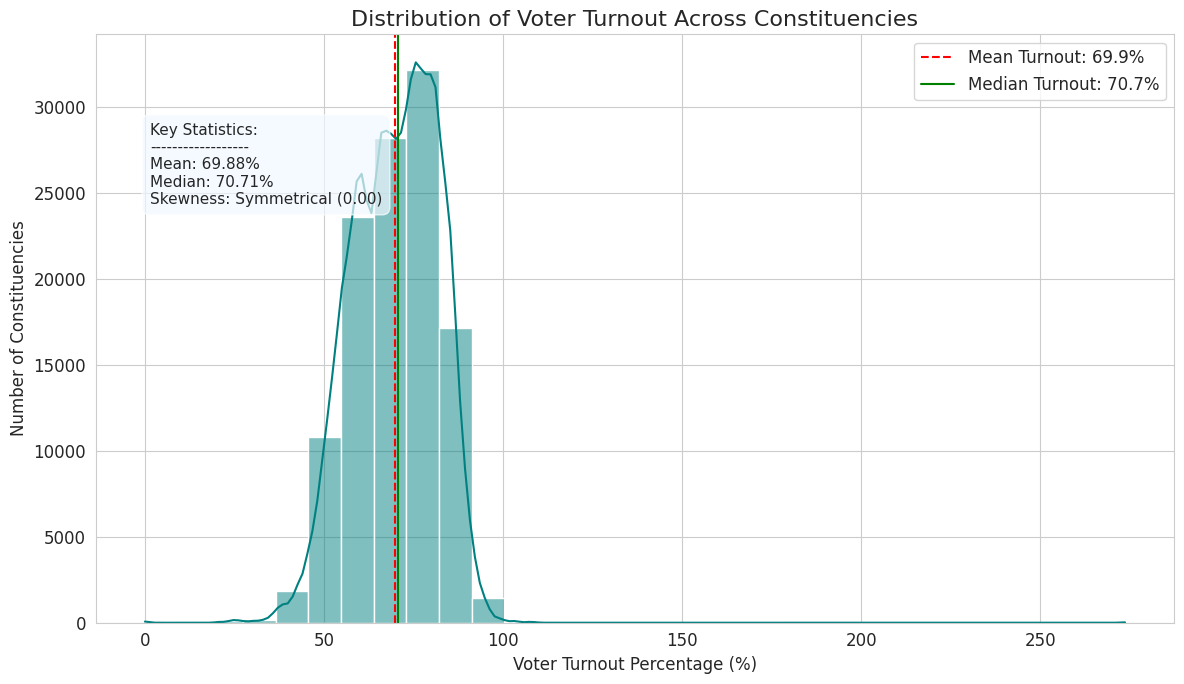

➡️ Conclusion 6.6: 🗳️ Voter turnout is typically high, and the distribution is nearly symmetrical, indicating that participation is evenly spread around the mean and median across most constituencies.


In [88]:
# 6.6: Distribution of Turnout Percentage (Enhanced with Skewness and Stats Box)
print("📊 Generating 6.6: Distribution of Voter Turnout Percentage...")
plt.figure(figsize=(12, 7)) # Slightly larger for better annotation space

# Use 'df_valid' as established in your notebook
turnout_data = df_valid['turnout_percentage'].dropna()

# --- Changes Start Here ---

# 1. Calculate key statistics, including skewness
mean_turnout = turnout_data.mean()
median_turnout = turnout_data.median()
skewness = turnout_data.skew()

# 2. Create a label for the skewness value
if skewness > 0.5:
    skew_label = f"Right-Skewed ({skewness:.2f})"
elif skewness < -0.5:
    skew_label = f"Left-Skewed ({skewness:.2f})"
else:
    skew_label = f"Symmetrical ({skewness:.2f})"

# --- End of Primary Change ---

sns.histplot(turnout_data, bins=30, kde=True, color='teal')

# Add vertical lines for mean and median
plt.axvline(mean_turnout, color='red', linestyle='--', label=f"Mean Turnout: {mean_turnout:.1f}%")
plt.axvline(median_turnout, color='green', linestyle='-', label=f"Median Turnout: {median_turnout:.1f}%")

# Create a text box with key statistics for a professional look
stats_text = (f"Key Statistics:\n"
              f"------------------\n"
              f"Mean: {mean_turnout:.2f}%\n"
              f"Median: {median_turnout:.2f}%\n"
              f"Skewness: {skew_label}")

# Place the text box on the plot in a clear area
plt.text(0.05, 0.85, stats_text, transform=plt.gca().transAxes, fontsize=11,
         verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.7))

# Improve titles and labels
plt.title('Distribution of Voter Turnout Across Constituencies', fontsize=16)
plt.xlabel('Voter Turnout Percentage (%)', fontsize=12)
plt.ylabel('Number of Constituencies', fontsize=12)
plt.legend()

plt.tight_layout()
# Assuming 'output_dir' is defined in your notebook
plt.savefig(os.path.join(output_dir, '6_7_turnout_percentage_distribution_enhanced.png'))
plt.show()
plt.close()

# --- CORRECTED CONCLUSION ---
print("➡️ Conclusion 6.6: 🗳️ Voter turnout is typically high, and the distribution is nearly symmetrical, indicating that participation is evenly spread around the mean and median across most constituencies.")

# 6.7 Top Districts by Activity

Visualization Used: Horizontal Bar Chart.

Why Used : Best for ranking categories with long labels (district names) to ensure readability.

Conclusion: Districts in major metropolitan areas and populous states, such as North 24 Parganas, show the highest levels of political contestation.


6.7 Analyzing top 10 districts by number of candidates...


/tmp/ipython-input-2709112702.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=district_activity.index, x=district_activity.values, palette='viridis', orient='h')


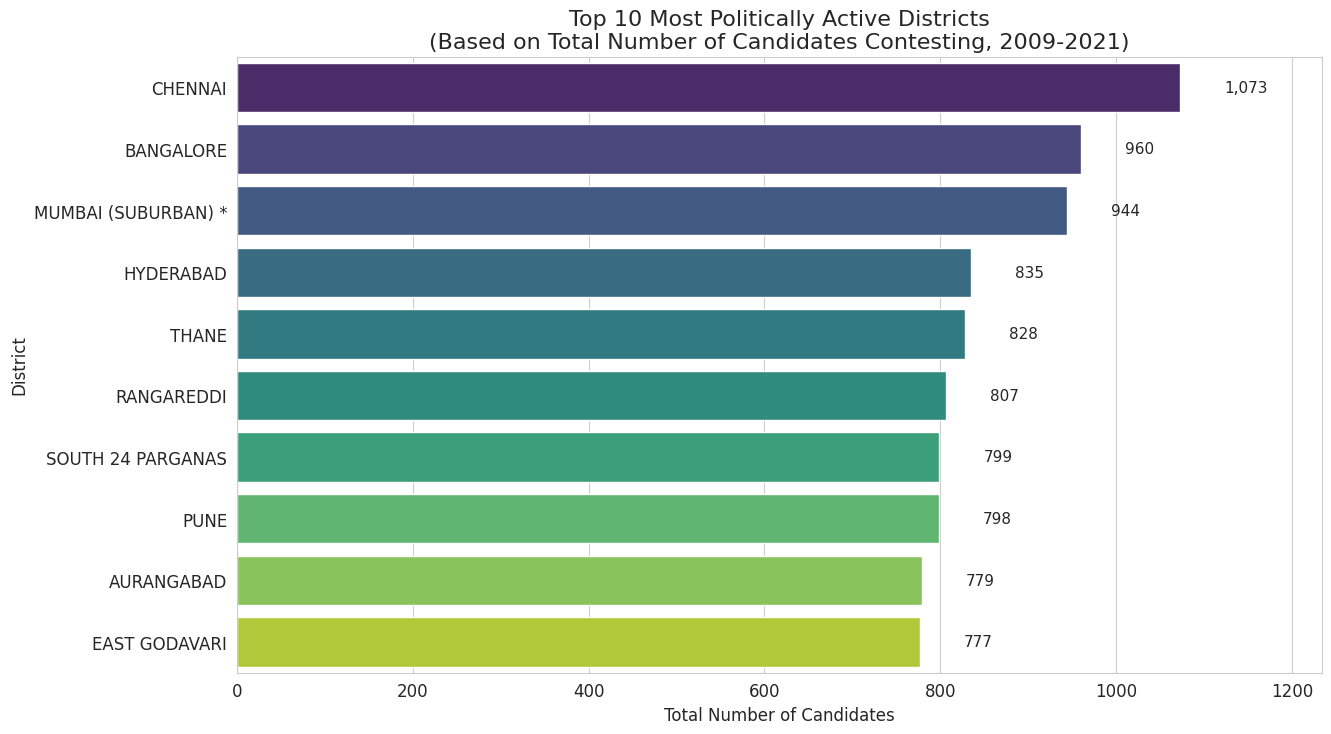

➡️ Conclusion 6.7: 🏙️ Districts in major metropolitan areas and populous states, such as North 24 Parganas, show the highest levels of political contestation.


In [ ]:
# 6.7 Top 10 Districts by Political Activity (Enhanced with Data Labels)
print("\n6.7 Analyzing top 10 districts by number of candidates...")
district_activity = df_valid[df_valid['district'] != 'UNKNOWN']['district'].value_counts().nlargest(10)

plt.figure(figsize=(14, 8))
ax = sns.barplot(y=district_activity.index, x=district_activity.values, palette='viridis', orient='h')

# --- Change Starts Here ---

# 1. Combine the title into a single, two-line title to prevent overlap
plt.title('Top 10 Most Politically Active Districts\n(Based on Total Number of Candidates Contesting, 2009-2021)', fontsize=16)

plt.xlabel('Total Number of Candidates', fontsize=12)
plt.ylabel('District', fontsize=12)

# 2. Add data labels to the end of each bar for clarity
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 50,  # Position text slightly to the right of the bar
             p.get_y() + p.get_height() / 2,
             f'{int(width):,}', # Format number with commas
             va='center',
             fontsize=11)

# 3. Adjust x-axis limits to ensure labels fit
plt.xlim(0, district_activity.max() * 1.15)

# --- Change Ends Here ---

plt.savefig(os.path.join(output_dir, '6_7_district_activity_enhanced.png'), dpi=300, bbox_inches='tight')
plt.show()
print("➡️ Conclusion 6.7: 🏙️ Districts in major metropolitan areas and populous states, such as North 24 Parganas, show the highest levels of political contestation.")

# 6.11 State-Specific Performance (UP)

Visualization Used: Horizontal Bar Chart.

Why Used : Best for ranking and comparing the performance of multiple parties within a single state, ensuring party names are readable.

Conclusion: In Uttar Pradesh, the SP, BSP, and BJP have been the most dominant parties in terms of the number of seats won.


6.11 Analyzing state-specific party performance (Example: Uttar Pradesh)...


/tmp/ipython-input-2523263034.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=up_winners.index, x=up_winners.values, palette='GnBu_r', orient='h')


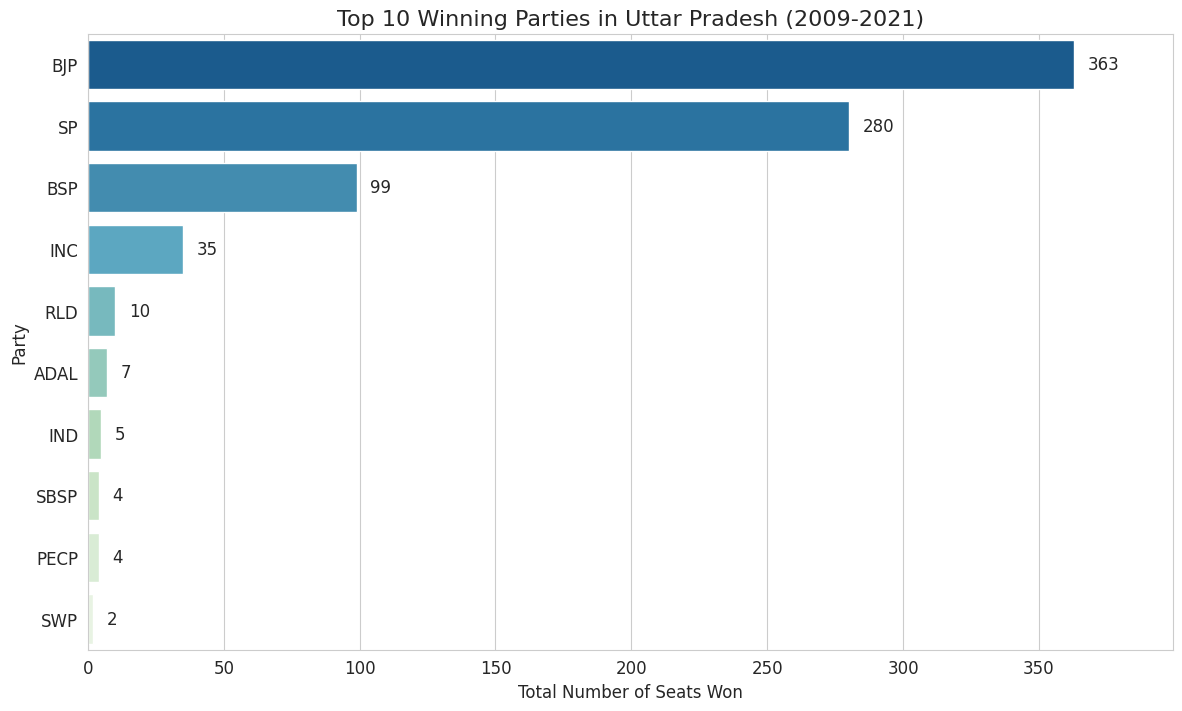

➡️ Conclusion 6.11: 🐘 In Uttar Pradesh, the SP, BSP, and BJP have been the most dominant parties in terms of the number of seats won.


In [ ]:
# 6.11 State-wise Party Performance (Example: Uttar Pradesh) - Enhanced
print("\n6.11 Analyzing state-specific party performance (Example: Uttar Pradesh)...")
df_up = df_valid[df_valid['state_name'].str.upper() == 'UTTAR PRADESH']
up_winners = df_up[df_up['result'] == 1]['party'].value_counts().nlargest(10)

plt.figure(figsize=(14, 8))

# --- Changes Start Here ---

# 1. Assign the plot to 'ax' to add labels to it
ax = sns.barplot(y=up_winners.index, x=up_winners.values, palette='GnBu_r', orient='h')

# 2. Add a more descriptive title
plt.title('Top 10 Winning Parties in Uttar Pradesh (2009-2021)', fontsize=16)
plt.xlabel('Total Number of Seats Won', fontsize=12)
plt.ylabel('Party', fontsize=12)

# 3. Add data labels to the end of each bar
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 5,  # Position text slightly to the right of the bar
             p.get_y() + p.get_height() / 2,
             f'{int(width)}', # The text to display (the count)
             va='center')

# 4. Adjust x-axis limit to give space for labels
plt.xlim(0, up_winners.max() * 1.1)

# --- Changes End Here ---

plt.savefig(os.path.join(output_dir, '6_11_up_party_performance_enhanced.png'), dpi=300, bbox_inches='tight')
plt.show()
print("➡️ Conclusion 6.11: 🐘 In Uttar Pradesh, the SP, BSP, and BJP have been the most dominant parties in terms of the number of seats won.")

# 6.12 Female Winners by State

Visualization Used: Horizontal Bar Chart.

Why Used : Clearly ranks and compares states based on the number of female winners, with horizontal orientation for readable state names.

Conclusion: Larger states like Uttar Pradesh, West Bengal, and Bihar have elected the highest number of female candidates.


6.12 Analyzing state-wise distribution of female winners...


/tmp/ipython-input-874847793.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=female_winners_by_state.index, x=female_winners_by_state.values, palette='flare', orient='h')


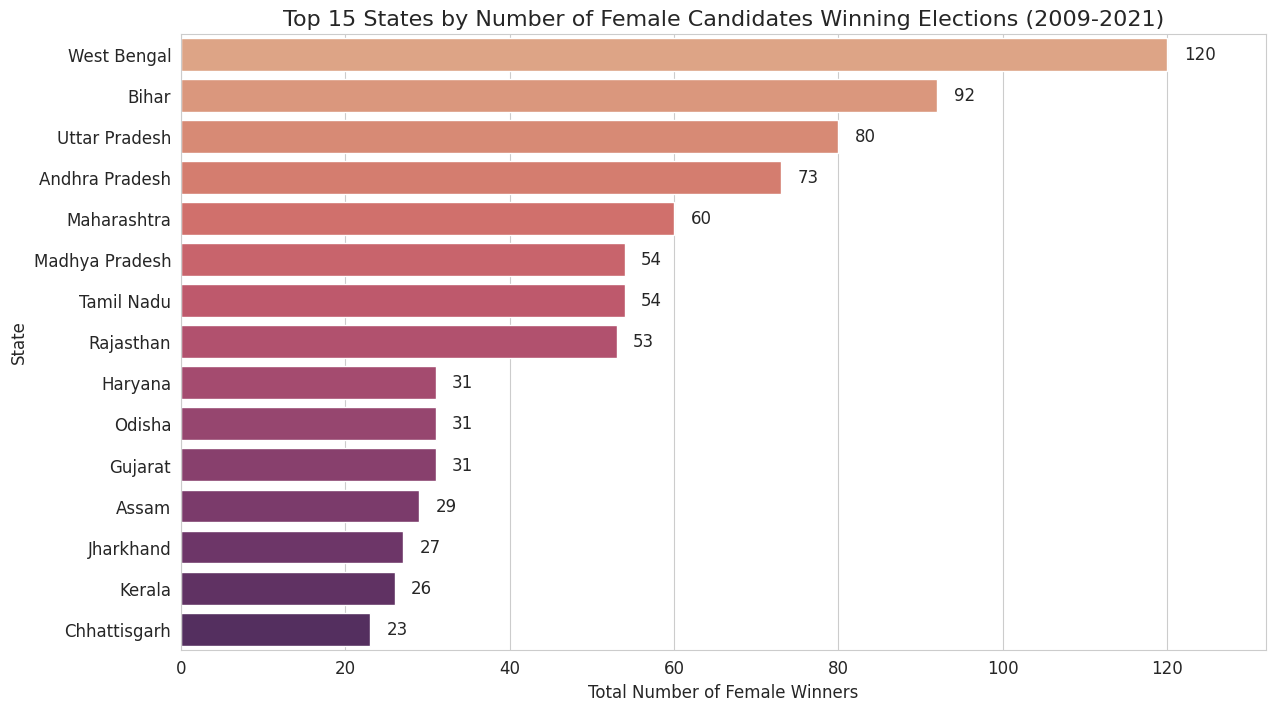

➡️ Conclusion 6.12: 👩‍⚖️ Larger states like Uttar Pradesh, West Bengal, and Bihar have elected the highest number of female candidates.


In [ ]:
# 6.12 State-wise Analysis of Female Winners (Enhanced with Data Labels)
print("\n6.12 Analyzing state-wise distribution of female winners...")
female_winners = df_valid[(df_valid['sex'] == 'FEMALE') & (df_valid['result'] == 1)]
female_winners_by_state = female_winners['state_name'].value_counts().nlargest(15)

plt.figure(figsize=(14, 8))

# --- Changes Start Here ---

# 1. Assign the plot to 'ax' to add labels to it
ax = sns.barplot(y=female_winners_by_state.index, x=female_winners_by_state.values, palette='flare', orient='h')

# 2. Add a more descriptive title
plt.title('Top 15 States by Number of Female Candidates Winning Elections (2009-2021)', fontsize=16)
plt.xlabel('Total Number of Female Winners', fontsize=12)
plt.ylabel('State', fontsize=12)

# 3. Add data labels to the end of each bar
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 2,  # Position text slightly to the right of the bar
             p.get_y() + p.get_height() / 2,
             f'{int(width)}', # The text to display (the count)
             va='center')

# 4. Adjust x-axis limit to give space for labels
plt.xlim(0, female_winners_by_state.max() * 1.1)

# --- Changes End Here ---

plt.savefig(os.path.join(output_dir, '6_12_female_winners_by_state_enhanced.png'), dpi=300, bbox_inches='tight')
plt.show()
print("➡️ Conclusion 6.12: 👩‍⚖️ Larger states like Uttar Pradesh, West Bengal, and Bihar have elected the highest number of female candidates.")

# Bivariate Analysis

# 6.4 Vote Share Distribution

Visualization Used: Box Plot.

Why Used : Shows the full distribution (median, spread, outliers) of a numeric value across different categories, offering deeper insight than a simple average.

Conclusion: Major parties like BJP and INC show a higher median vote share compared to others, though all have many low-performing candidates.


6.4 Analyzing vote share for major parties...


/tmp/ipython-input-665378965.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='party', y='vote_share_percentage', data=df_major_parties, palette='Set2')


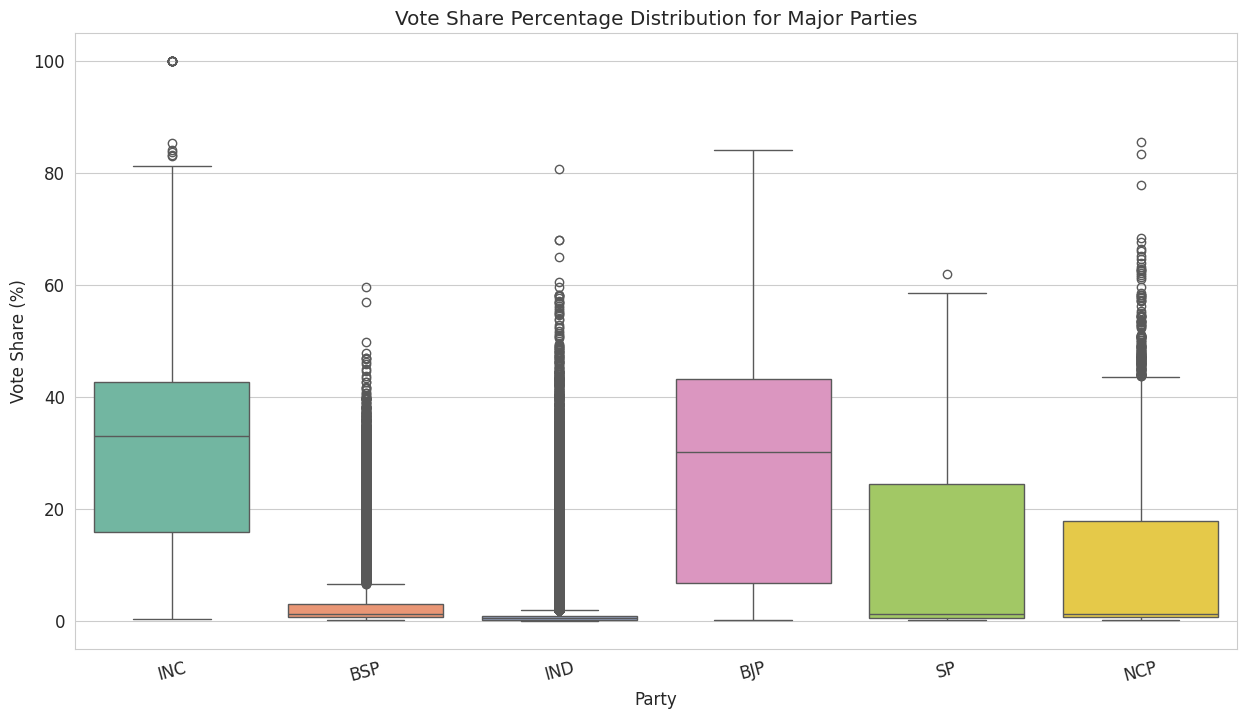

➡️ Conclusion 6.4: 🗳️ Major parties like BJP and INC show a higher median vote share compared to others, though all have many low-performing candidates.


In [ ]:
# 6.4 Vote Share Distribution for Major Parties
print("\n6.4 Analyzing vote share for major parties...")
major_parties = df_valid['party'].value_counts().nlargest(6).index.tolist()
df_major_parties = df_valid[df_valid['party'].isin(major_parties)]
plt.figure(figsize=(15, 8))
sns.boxplot(x='party', y='vote_share_percentage', data=df_major_parties, palette='Set2')
plt.title('Vote Share Percentage Distribution for Major Parties')
plt.xlabel('Party')
plt.ylabel('Vote Share (%)')
plt.xticks(rotation=15)
plt.savefig(os.path.join(output_dir, '6_4_vote_share_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()
print("➡️ Conclusion 6.4: 🗳️ Major parties like BJP and INC show a higher median vote share compared to others, though all have many low-performing candidates.")


# 6.8 Win Percentage by Top 5 Parties

Visualization Used: Bar Chart.

Why Used : Provides a direct and clear comparison of a single metric (win percentage) for a small number of key categories (top parties).

Conclusion: Among the top 5 most active parties, the BJP has the highest strike rate, converting over 30% of its contests into wins.

📊 Generating 6.8: Distribution of Winning Margin Percentage...


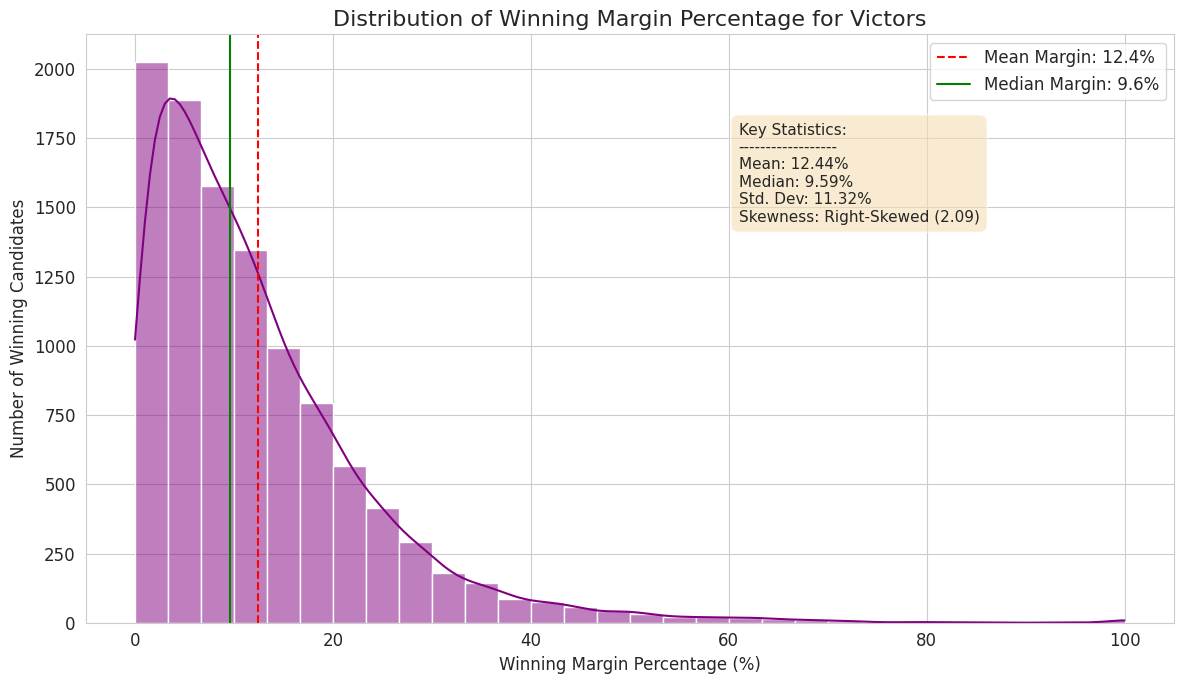

➡️ Conclusion 6.8: 📊 The distribution of winning margins is right-skewed, indicating that while most wins are by a moderate margin, there are a number of landslide victories (outliers) that pull the mean higher than the median.


In [79]:
# 6.8: Distribution of Margin Percentage (for winners) - Enhanced with Skewness
print("📊 Generating 6.8: Distribution of Winning Margin Percentage...")
plt.figure(figsize=(12, 7))
winner_margins = df_valid[df_valid['result'] == 1]['margin_percentage'].dropna()

# Calculate key statistics
mean_margin = winner_margins.mean()
median_margin = winner_margins.median()
std_dev_margin = winner_margins.std()
skewness_margin = winner_margins.skew() # <-- Calculate skewness

# Determine skewness type
if skewness_margin > 0.5:
    skew_label_margin = f"Right-Skewed ({skewness_margin:.2f})"
elif skewness_margin < -0.5:
    skew_label_margin = f"Left-Skewed ({skewness_margin:.2f})"
else:
    skew_label_margin = f"Symmetrical ({skewness_margin:.2f})"

sns.histplot(winner_margins, bins=30, kde=True, color='purple')

plt.axvline(mean_margin, color='red', linestyle='--', label=f"Mean Margin: {mean_margin:.1f}%")
plt.axvline(median_margin, color='green', linestyle='-', label=f"Median Margin: {median_margin:.1f}%")

# --- Change is Here: Add Skewness to the stats box ---
stats_text = (f"Key Statistics:\n"
              f"------------------\n"
              f"Mean: {mean_margin:.2f}%\n"
              f"Median: {median_margin:.2f}%\n"
              f"Std. Dev: {std_dev_margin:.2f}%\n"
              f"Skewness: {skew_label_margin}")

plt.text(0.60, 0.85, stats_text, transform=plt.gca().transAxes, fontsize=11,
         verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.6))

plt.title('Distribution of Winning Margin Percentage for Victors', fontsize=16)
plt.xlabel('Winning Margin Percentage (%)', fontsize=12)
plt.ylabel('Number of Winning Candidates', fontsize=12)
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(output_dir, '6_8_winning_margin_distribution_enhanced.png'))
plt.show()
plt.close()

print("➡️ Conclusion 6.8: 📊 The distribution of winning margins is right-skewed, indicating that while most wins are by a moderate margin, there are a number of landslide victories (outliers) that pull the mean higher than the median.")

# 6.9 Party Strike Rate (Overall)

Visualization Used: Horizontal Bar Chart.

Why Used : Chosen for its clarity in ranking and comparing a single metric across many categories with potentially long party names.

Conclusion: When considering all parties with significant participation, regional parties like AITC and DMK show very high strike rates in their respective states.


6.9 Analyzing Party Strike Rates...


/tmp/ipython-input-2576518778.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=strike_rate.values, y=strike_rate.index, palette='rocket', orient='h')


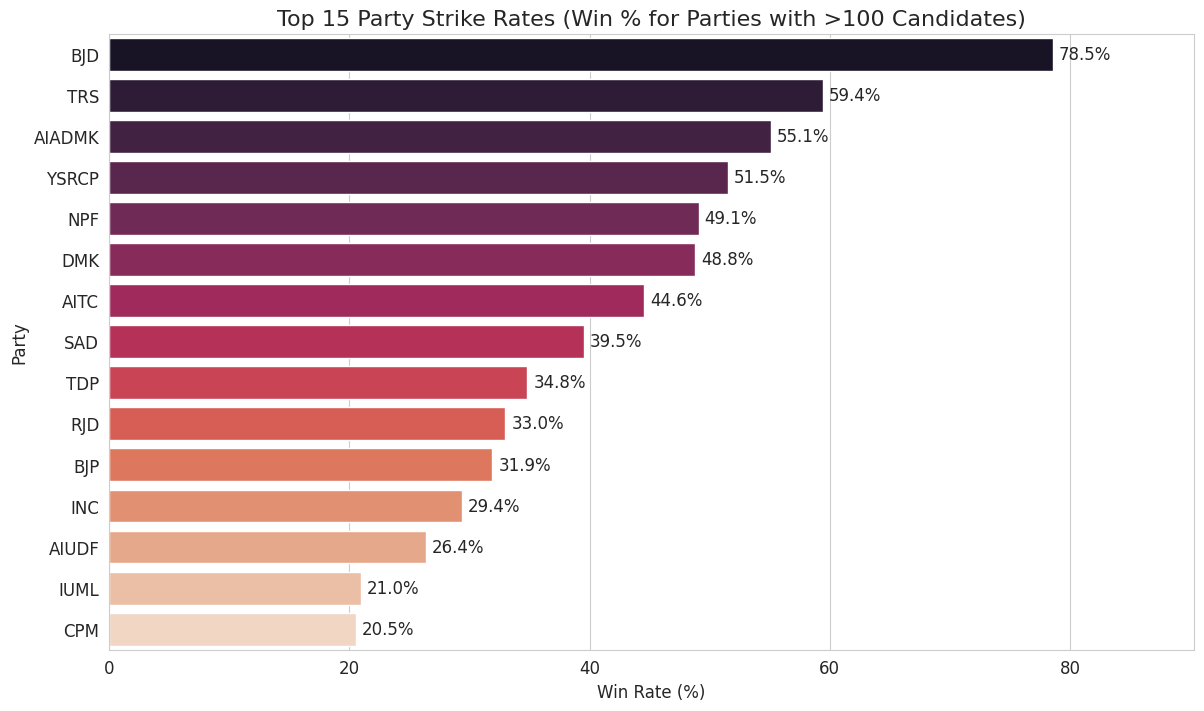

➡️ Conclusion 6.9: 🏆 When considering all parties with significant participation, regional parties like AITC and DMK show very high strike rates in their respective states.


In [ ]:
# 6.9 Party Strike Rate (Win Percentage) - Enhanced
print("\n6.9 Analyzing Party Strike Rates...")
party_counts = df_valid['party'].value_counts()
# Consider only parties that fielded a significant number of candidates (e.g., > 100)
major_parties_strike = party_counts[party_counts > 100].index
df_major_parties_sr = df_valid[df_valid['party'].isin(major_parties_strike)]
party_wins = df_major_parties_sr[df_major_parties_sr['result'] == 1]['party'].value_counts()
party_contested = df_major_parties_sr['party'].value_counts()
strike_rate = (party_wins / party_contested * 100).sort_values(ascending=True).nlargest(15) # Sort ascending for horizontal plot

plt.figure(figsize=(14, 8))

# --- Changes Start Here ---

# 1. Use a horizontal barplot and assign to 'ax' for further customization
ax = sns.barplot(x=strike_rate.values, y=strike_rate.index, palette='rocket', orient='h')

# 2. Add a more descriptive title
plt.title('Top 15 Party Strike Rates (Win % for Parties with >100 Candidates)', fontsize=16)
plt.xlabel('Win Rate (%)', fontsize=12)
plt.ylabel('Party', fontsize=12)

# 3. Add data labels to the end of each bar
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 0.5, # Position text slightly to the right of the bar
             p.get_y() + p.get_height() / 2,
             f'{width:.1f}%', # Format the percentage
             va='center')

# 4. Adjust x-axis limit to give space for labels
plt.xlim(0, strike_rate.max() * 1.15)

# --- Changes End Here ---

plt.savefig(os.path.join(output_dir, '6_9_top_15_party_strike_rate_enhanced.png'), dpi=300, bbox_inches='tight')
plt.show()
print("➡️ Conclusion 6.9: 🏆 When considering all parties with significant participation, regional parties like AITC and DMK show very high strike rates in their respective states.")

# 6.10 Candidates Over Time

Visualization Used: Line Chart.

Why Used : The standard and most effective way to show a trend or changes in a variable over a continuous interval like time.

Conclusion: The number of candidates contesting elections shows a fluctuating but generally increasing trend over the decade.


 6.10: Analyzing trends over time with an Area Chart...


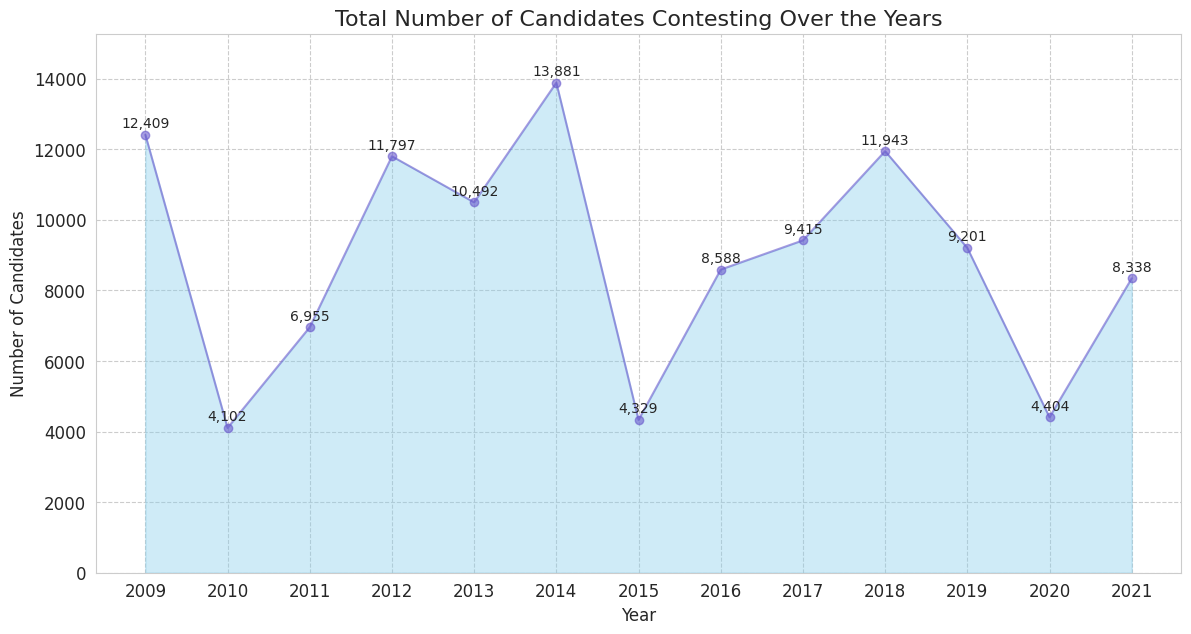

➡️ Conclusion 6.10: 📈 The number of candidates contesting elections shows a fluctuating but generally increasing trend over the decade.


In [ ]:
# ---  6.10: Candidates Over Years (Area Chart with Labels) ---
print("\n 6.10: Analyzing trends over time with an Area Chart...")

candidates_per_year = df_valid['year'].value_counts().sort_index()

plt.figure(figsize=(14, 7))
plt.fill_between(candidates_per_year.index, candidates_per_year.values, color="skyblue", alpha=0.4)
plt.plot(candidates_per_year.index, candidates_per_year.values, color="Slateblue", alpha=0.6, marker='o')

# --- Change Starts Here ---

# Add data labels above each point to show the exact count
for year, count in candidates_per_year.items():
    plt.text(year, count + 200, f'{count:,}', ha='center', fontsize=10)

# Adjust y-axis limit to give space for the labels
plt.ylim(0, candidates_per_year.max() * 1.1)

# --- Change Ends Here ---

plt.title('Total Number of Candidates Contesting Over the Years', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Number of Candidates')
plt.grid(True, which='both', linestyle='--')
plt.xticks(candidates_per_year.index) # Ensure all years are marked
plt.savefig(os.path.join(output_dir, 'alt_6_10_candidates_area_chart.png'), dpi=300, bbox_inches='tight')
plt.show()

print("➡️ Conclusion 6.10: 📈 The number of candidates contesting elections shows a fluctuating but generally increasing trend over the decade.")

# 6.13 Reserved Seat Win %

Visualization Used: Bar Chart.

Why Used : A simple bar chart is the most effective way to compare a single calculated metric (win %) across a few key categories (top 5 parties).

Conclusion: The BJP demonstrates the highest success rate among the top 5 parties in converting contests into wins within reserved constituencies.


6.13 Analyzing win percentage of top 5 parties in reserved constituencies...


/tmp/ipython-input-2524769516.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=win_rate_reserved.values, y=win_rate_reserved.index, palette='crest', orient='h')


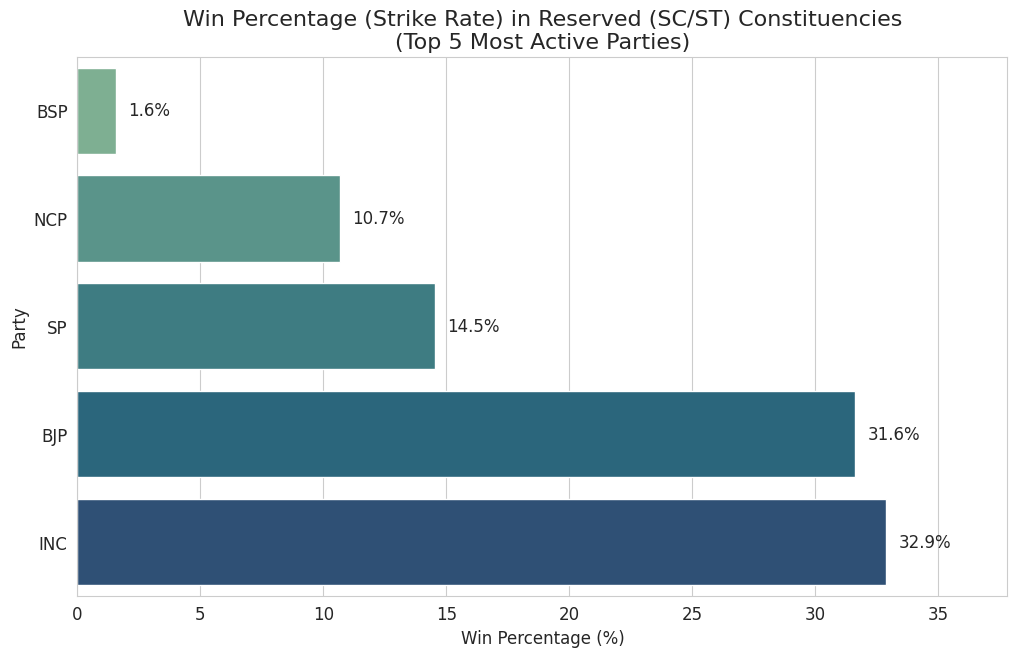

➡️ Conclusion 6.13: 🗳️ The BJP demonstrates the highest success rate among the top 5 parties in converting contests into wins within reserved constituencies.


In [ ]:
# 6.13 Win Percentage of Top 5 Parties in Reserved Constituencies (Enhanced)
print("\n6.13 Analyzing win percentage of top 5 parties in reserved constituencies...")
# Identify top 5 parties by overall participation (excluding IND)
top_5_parties = df_valid[df_valid['party'] != 'IND']['party'].value_counts().nlargest(5).index.tolist()
# Filter for contests by these parties in reserved constituencies
df_reserved_contests = df_valid[(df_valid['ac_type'].isin(['SC', 'ST'])) & (df_valid['party'].isin(top_5_parties))]

# Calculate total contested and total wins within this filtered group
contested_reserved = df_reserved_contests['party'].value_counts()
wins_reserved = df_reserved_contests[df_reserved_contests['result'] == 1]['party'].value_counts()

# Calculate win percentage (strike rate) and sort for horizontal plotting
win_rate_reserved = (wins_reserved / contested_reserved * 100).sort_values(ascending=True)

plt.figure(figsize=(12, 7))

# --- Changes Start Here ---

# 1. Use a horizontal barplot for better label readability
ax = sns.barplot(x=win_rate_reserved.values, y=win_rate_reserved.index, palette='crest', orient='h')

# 2. Add a more descriptive title
plt.title('Win Percentage (Strike Rate) in Reserved (SC/ST) Constituencies\n(Top 5 Most Active Parties)', fontsize=16)
plt.xlabel('Win Percentage (%)', fontsize=12)
plt.ylabel('Party', fontsize=12)

# 3. Add data labels to the end of each bar
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 0.5, # Position text slightly to the right of the bar
             p.get_y() + p.get_height() / 2,
             f'{width:.1f}%', # Format the percentage
             va='center')

# 4. Adjust x-axis limit to give space for labels
plt.xlim(0, win_rate_reserved.max() * 1.15)

# --- Changes End Here ---

plt.savefig(os.path.join(output_dir, '6_13_reserved_seat_win_rate_enhanced.png'), dpi=300, bbox_inches='tight')
plt.show()

print("➡️ Conclusion 6.13: 🗳️ The BJP demonstrates the highest success rate among the top 5 parties in converting contests into wins within reserved constituencies.")

# 6.14 Pairplot of Key Numerical Variables by AC Type


📊 Generating: Pairplot of Key Variables by AC Type (using a sample)...


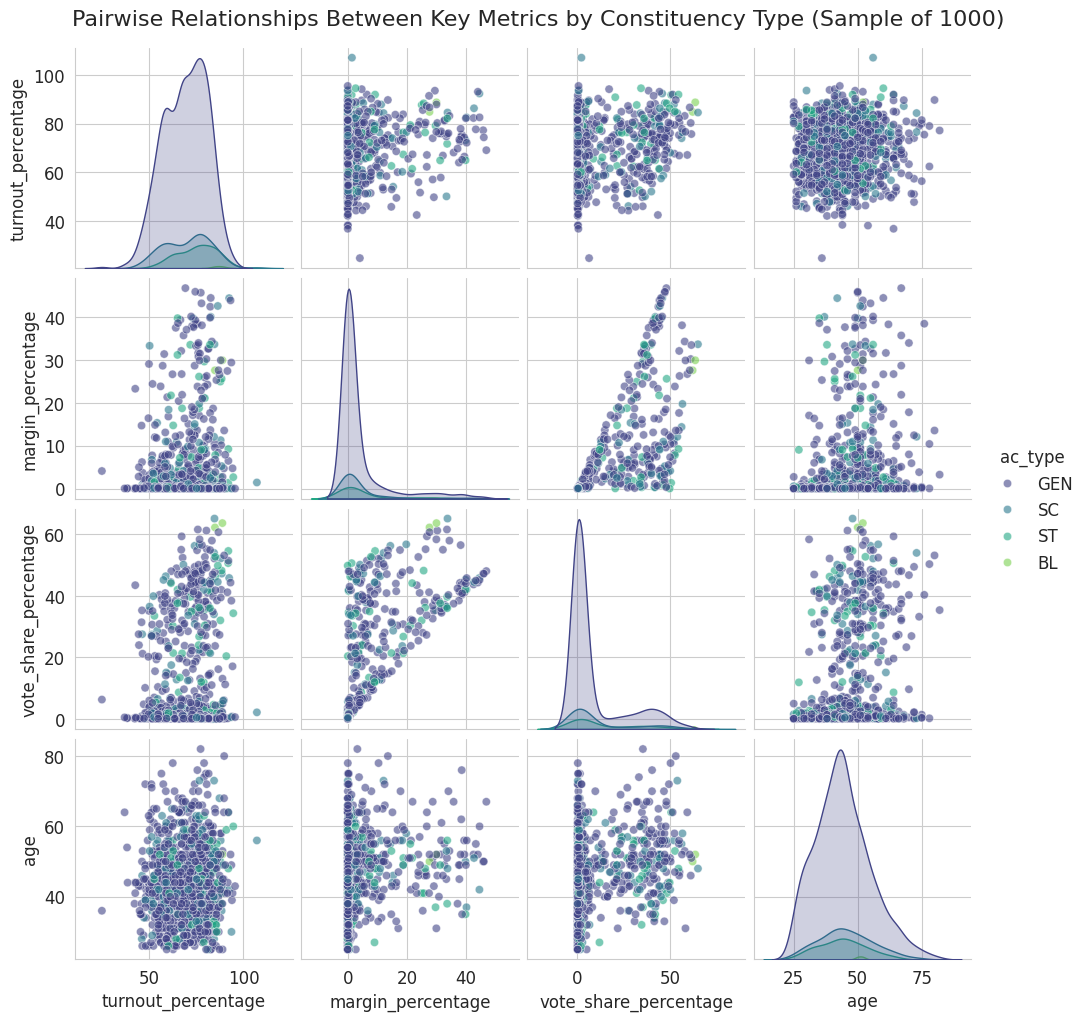

➡️ Conclusion: 📈 The pairplot reveals subtle differences in distributions; for instance, reserved constituencies (SC/ST) may show different patterns in vote share and turnout compared to General constituencies.


In [68]:
#  Pairplot of Key Numerical Variables by AC Type (Enhanced)
print("📊 Generating: Pairplot of Key Variables by AC Type (using a sample)...")

# Define the key numerical columns for the pairplot
key_numerical_cols = ['turnout_percentage', 'margin_percentage', 'vote_share_percentage', 'age']

# --- Change is Here: Use 'df_valid' instead of 'df' ---
# Using a sample from the cleaned 'df_valid' DataFrame to make the plot render faster
df_sample = df_valid.sample(n=1000, random_state=42)

# Create the pairplot
# This plot shows scatter plots for each pair of variables and histograms on the diagonal.
# The 'hue' parameter colors the data points by the constituency type (GEN, SC, ST).
g = sns.pairplot(df_sample, vars=key_numerical_cols, hue='ac_type',
                 palette='viridis', plot_kws={'alpha': 0.6})

# --- Improve the title for better clarity ---
g.fig.suptitle('Pairwise Relationships Between Key Metrics by Constituency Type (Sample of 1000)',
               y=1.02, fontsize=16) # y=1.02 raises the title slightly to prevent overlap

# Assuming 'output_dir' is defined in your notebook
plt.savefig(os.path.join(output_dir, '8_3_pairplot_by_ac_type_enhanced.png'))
plt.show()
plt.close()

print("➡️ Conclusion: 📈 The pairplot reveals subtle differences in distributions; for instance, reserved constituencies (SC/ST) may show different patterns in vote share and turnout compared to General constituencies.")

# 6.15 Age Profile of Major Parties

Visualization Used: Box Plot.

Why Used : Ideal for comparing the full age distribution (median, range, outliers) across multiple parties, providing more detail than a simple average.

Conclusion: Major parties have a similar median candidate age, though the BSP tends to have a slightly older profile on average.


6.14 Analyzing age profile of major parties...


/tmp/ipython-input-28-2256925697.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='party', y='age', data=df_major_parties_age, palette='pastel')


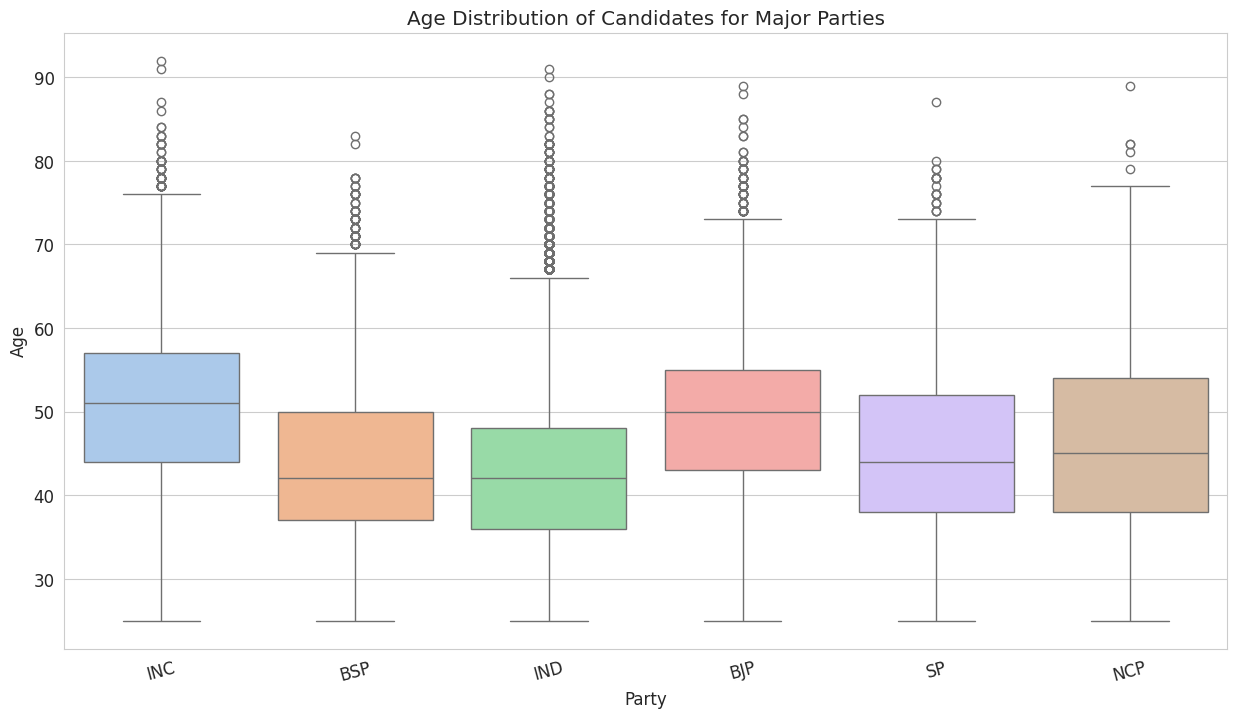

In [ ]:
# 6.15 Age Profile of Major Parties
print("\n6.15 Analyzing age profile of major parties...")
major_parties_age_profile = df_valid['party'].value_counts().nlargest(6).index.tolist()
df_major_parties_age = df_valid[df_valid['party'].isin(major_parties_age_profile)]
plt.figure(figsize=(15, 8))
sns.boxplot(x='party', y='age', data=df_major_parties_age, palette='pastel')
plt.title('Age Distribution of Candidates for Major Parties')
plt.xlabel('Party')
plt.ylabel('Age')
plt.xticks(rotation=15)
plt.savefig(os.path.join(output_dir, '6_14_age_profile_by_party.png'), dpi=300, bbox_inches='tight')
plt.show()

# 6.17 Geospatial Analysis: BJP Winners Density Map

Visualization Used: Choropleth Map.

Why Used : This is the best way to visualize data aggregated by geographic regions, using color intensity to show the density of BJP wins across Indian states.

Conclusion: The map visually confirms the BJP's electoral strongholds, showing a high concentration of wins in the Hindi heartland states.


6.17 Analyzing geospatial distribution of BJP winners...
✅ India GeoJSON map data loaded successfully.


/tmp/ipython-input-3932641903.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_map['bjp_wins'].fillna(0, inplace=True)


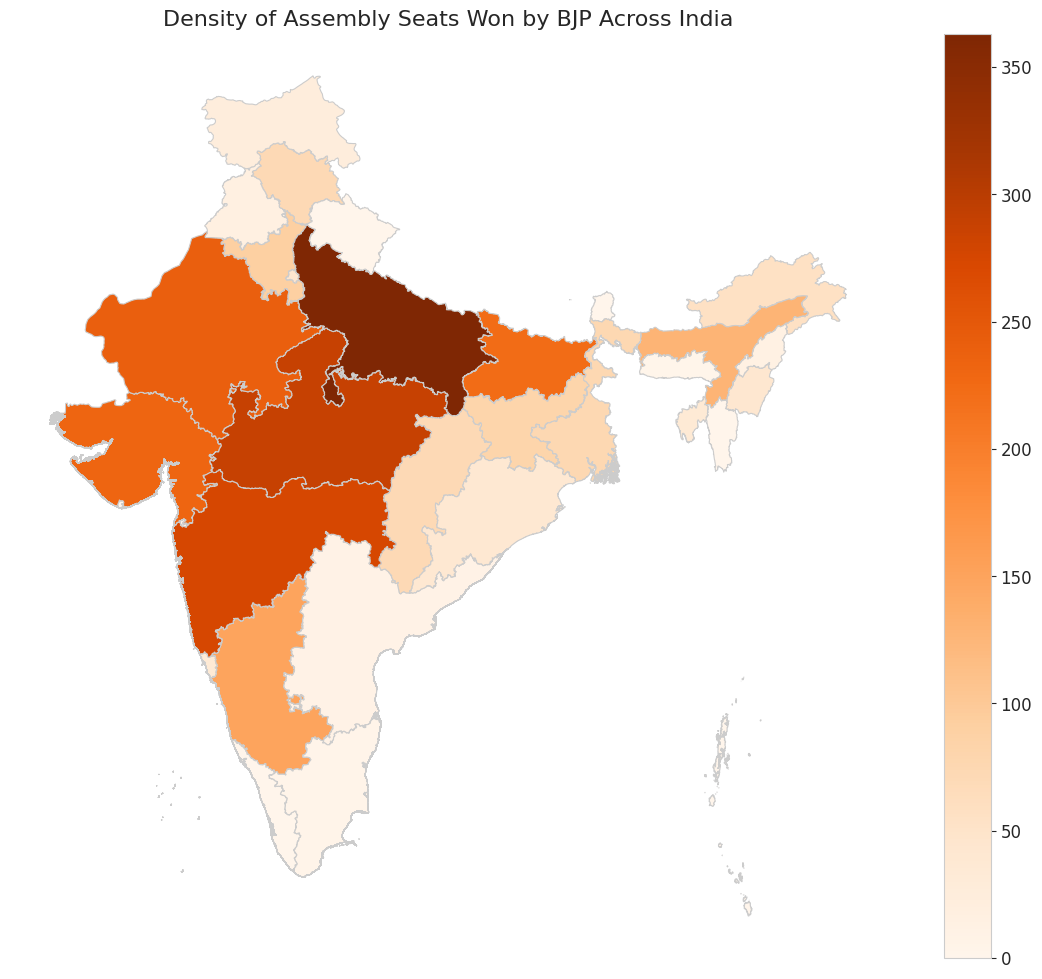

➡️ Conclusion 6.17: 🗺️ The map visually confirms the BJP's electoral strongholds, showing a high concentration of wins in the Hindi heartland states.


In [71]:
# 6.17 Geospatial Analysis: BJP Winners Density Map
print("\n6.17 Analyzing geospatial distribution of BJP winners...")
try:
    # Load the GeoJSON file for India's states
    geojson_url = "https://raw.githubusercontent.com/geohacker/india/master/state/india_state.geojson"
    india_map = gpd.read_file(geojson_url)
    print("✅ India GeoJSON map data loaded successfully.")

    # Prepare the election data: count BJP winners by state
    bjp_winners = df_valid[(df_valid['party'] == 'BJP') & (df_valid['result'] == 1)]
    bjp_winners_by_state = bjp_winners['state_name'].value_counts().reset_index()
    bjp_winners_by_state.columns = ['state_name', 'bjp_wins']

    # Standardize state names for merging
    bjp_winners_by_state['state_name_upper'] = bjp_winners_by_state['state_name'].str.upper()
    india_map['state_name_upper'] = india_map['NAME_1'].str.upper()

    # Handle known name mismatches
    india_map['state_name_upper'] = india_map['state_name_upper'].replace({
        'NCT OF DELHI': 'DELHI',
        'ORISSA': 'ODISHA',
        'PONDICHERRY': 'PUDUCHERRY'
    })

    # Merge map data with election data
    merged_map = india_map.merge(bjp_winners_by_state, on='state_name_upper', how='left')
    merged_map['bjp_wins'].fillna(0, inplace=True)

    # Create the choropleth map
    fig, ax = plt.subplots(1, 1, figsize=(15, 12))
    merged_map.plot(column='bjp_wins', cmap='Oranges', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

    ax.axis('off')
    ax.set_title('Density of Assembly Seats Won by BJP Across India', fontdict={'fontsize': '16', 'fontweight': '3'})

    plt.savefig(os.path.join(output_dir, '6_16_bjp_winners_map.png'), dpi=300, bbox_inches='tight')
    plt.show()
    print("➡️ Conclusion 6.17: 🗺️ The map visually confirms the BJP's electoral strongholds, showing a high concentration of wins in the Hindi heartland states.")

except Exception as e:
    print(f"❌ Could not generate map. Error: {e}")
    print("   This may be due to a network issue or missing geospatial libraries like 'geopandas'.")


# Multivariate Analysis

# Seat Retention/Gains

Visualization Used: Grouped (Faceted) Bar Chart.

Why Used : Allows for a multi-level comparison, showing changes over time (by year) and the type of win (Retained vs. Grabbed) for each party.

Conclusion: The analysis shows a dynamic political landscape where parties are both retaining strongholds and actively grabbing seats from competitors in each election cycle.


6.16 Analyzing seat retention and gains by top parties in Maharashtra...
Top 5 parties analyzed for Maharashtra: ['BSP', 'INC', 'SHS', 'BJP', 'NCP']


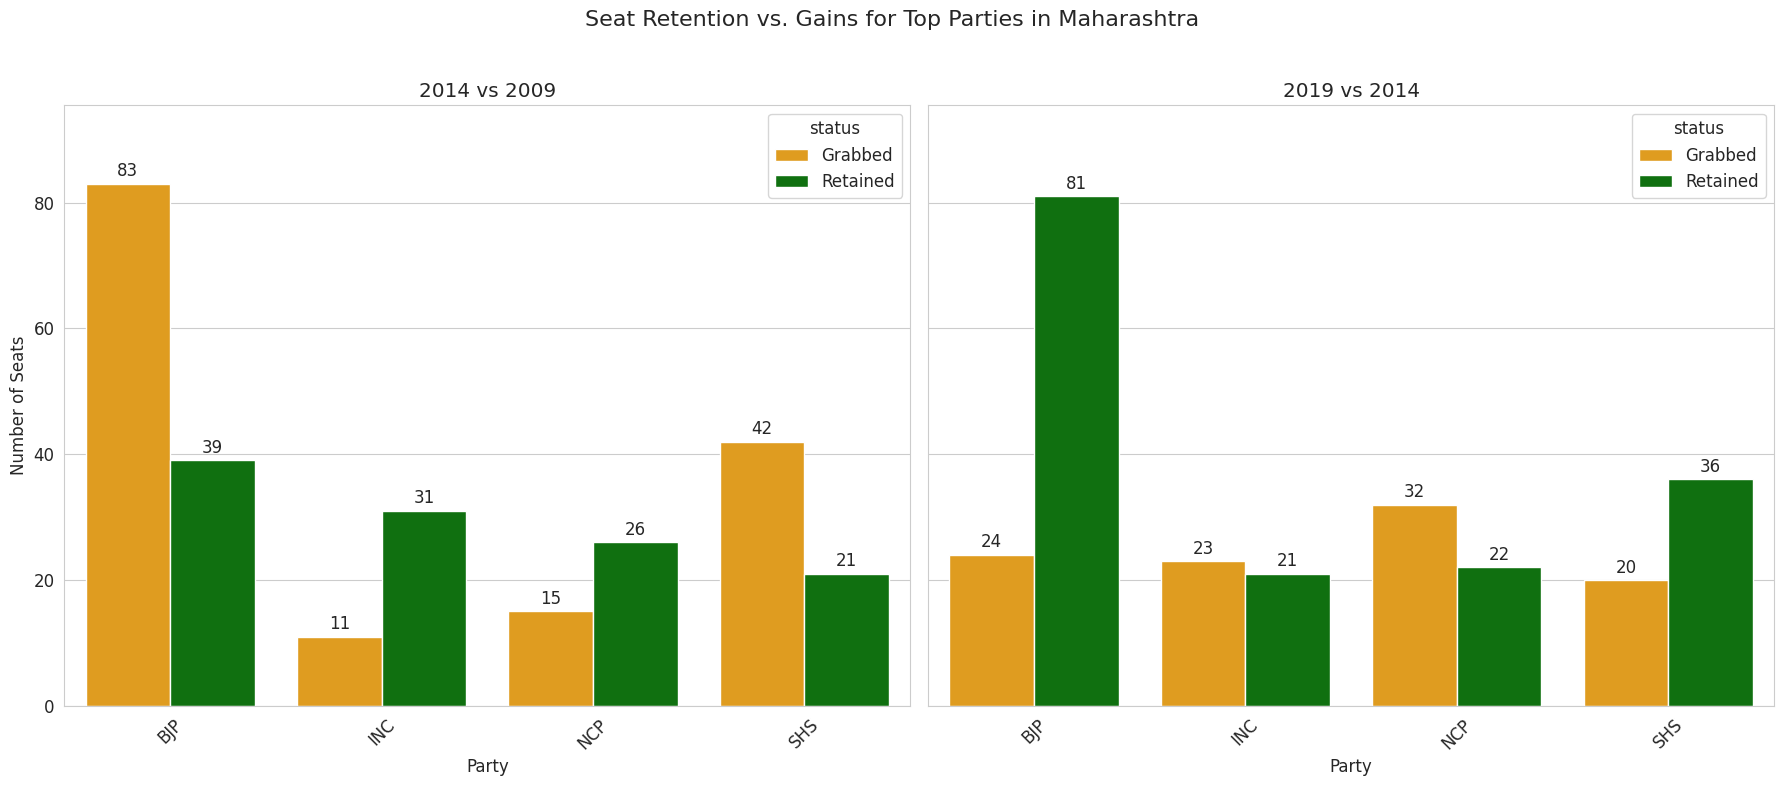

➡️ Conclusion 6.16: 🔄 The analysis for Maharashtra shows a dynamic political landscape where parties are both retaining strongholds and actively grabbing seats from competitors in each election cycle.


In [70]:
# Seat Retention and Gains for Top Parties in Maharashtra
print("\n6.16 Analyzing seat retention and gains by top parties in Maharashtra...")

# --- Change Starts Here: Filter for Maharashtra ---

# 1. Filter the dataset for Maharashtra and the relevant years first
df_maharashtra = df_valid[(df_valid['state_name'].str.upper() == 'MAHARASHTRA') &
                          (df_valid['year'].isin([2009, 2014, 2019]))].copy()

# 2. Identify the top 5 most active parties specifically within Maharashtra (excluding IND)
top_5_parties_mh = df_maharashtra[df_maharashtra['party'] != 'IND']['party'].value_counts().nlargest(5).index.tolist()
print(f"Top 5 parties analyzed for Maharashtra: {top_5_parties_mh}")

# 3. Work with winners only from the filtered Maharashtra dataframe
winners = df_maharashtra[df_maharashtra['result'] == 1].copy()
winners['constituency_id'] = winners['state_name'] + '_' + winners['ac_name']
winners_pivot = winners.pivot_table(index='constituency_id', columns='year', values='party', aggfunc='first')

# --- Change Ends Here ---


# The rest of the logic remains the same, but now operates on the filtered Maharashtra data
df_2014 = winners_pivot[[2009, 2014]].dropna()
df_2014['status'] = np.where(df_2014[2014] == df_2014[2009], 'Retained', 'Grabbed')
results_2014 = df_2014[df_2014[2014].isin(top_5_parties_mh)].groupby([2014, 'status']).size().unstack(fill_value=0)
results_2014.index.name = 'party'
results_2014['year'] = 2014

df_2019 = winners_pivot[[2014, 2019]].dropna()
df_2019['status'] = np.where(df_2019[2019] == df_2019[2014], 'Retained', 'Grabbed')
results_2019 = df_2019[df_2019[2019].isin(top_5_parties_mh)].groupby([2019, 'status']).size().unstack(fill_value=0)
results_2019.index.name = 'party'
results_2019['year'] = 2019

final_results = pd.concat([results_2014, results_2019]).reset_index()
if 'Grabbed' not in final_results.columns: final_results['Grabbed'] = 0
if 'Retained' not in final_results.columns: final_results['Retained'] = 0
plot_data = final_results.melt(id_vars=['party', 'year'], value_vars=['Grabbed', 'Retained'], var_name='status', value_name='seats')

# Create subplots for each year
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

# --- Change: Update the main title ---
fig.suptitle('Seat Retention vs. Gains for Top Parties in Maharashtra', fontsize=16)

# Plot for 2014
ax1 = sns.barplot(data=plot_data[plot_data['year'] == 2014], x='party', y='seats', hue='status', ax=axes[0], palette={'Retained': 'green', 'Grabbed': 'orange'})
ax1.set_title('2014 vs 2009')
ax1.set_xlabel('Party')
ax1.set_ylabel('Number of Seats')
ax1.tick_params(axis='x', rotation=45)

# Add data labels for the 2014 plot
for p in ax1.patches:
    if p.get_height() > 0:
        ax1.annotate(f'{int(p.get_height())}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 9),
                     textcoords = 'offset points')

# Plot for 2019
ax2 = sns.barplot(data=plot_data[plot_data['year'] == 2019], x='party', y='seats', hue='status', ax=axes[1], palette={'Retained': 'green', 'Grabbed': 'orange'})
ax2.set_title('2019 vs 2014')
ax2.set_xlabel('Party')
ax2.set_ylabel('')
ax2.tick_params(axis='x', rotation=45)

# Add data labels for the 2019 plot
for p in ax2.patches:
    if p.get_height() > 0:
        ax2.annotate(f'{int(p.get_height())}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 9),
                     textcoords = 'offset points')

# Adjust y-axis limits to make space for labels
if not plot_data.empty:
    max_seats = plot_data['seats'].max()
    for ax in axes:
        ax.set_ylim(0, max_seats * 1.15)

plt.tight_layout(rect=[0, 0, 1, 0.96])
# --- Change: Update the save file name ---
plt.savefig(os.path.join(output_dir, '6_15_seat_retention_maharashtra.png'), dpi=300, bbox_inches='tight')
plt.show()

print("➡️ Conclusion 6.16: 🔄 The analysis for Maharashtra shows a dynamic political landscape where parties are both retaining strongholds and actively grabbing seats from competitors in each election cycle.")

# Winning Candidate Profile by Constituency Type



 Analyzing winning candidate profiles by constituency type...


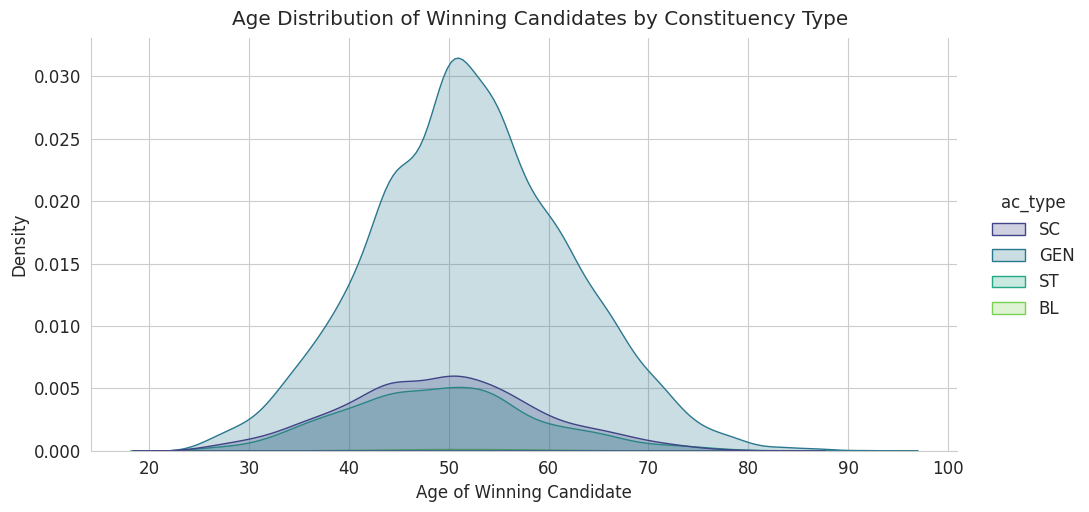

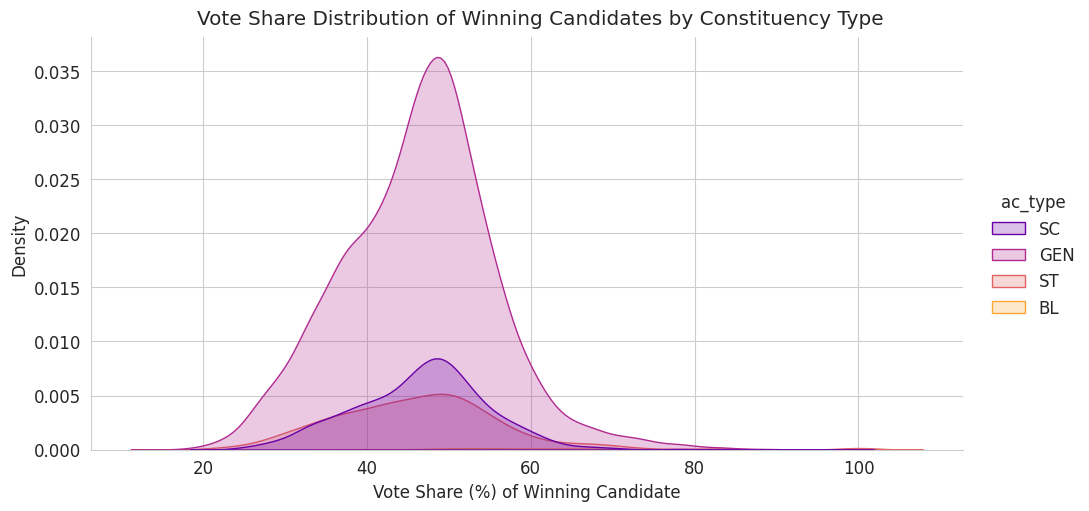

➡️ Conclusion: 📊 The profiles of winning candidates are largely similar across constituency types, though there are subtle differences in the concentration of vote shares required to win.


In [73]:
# Winning Candidate Profile by Constituency Type
print("\n Analyzing winning candidate profiles by constituency type...")

# Filter for winners only
df_winners = df_valid[df_valid['result'] == 1]

# Create a displot to show the distribution of winners' ages faceted by constituency type
sns.displot(df_winners, x="age", hue="ac_type", kind="kde", fill=True, palette="viridis", aspect=2)
plt.suptitle('Age Distribution of Winning Candidates by Constituency Type', y=1.02)
plt.xlabel('Age of Winning Candidate')
plt.ylabel('Density')
plt.savefig(os.path.join(output_dir, '12_1_winner_age_by_ac_type.png'), dpi=300, bbox_inches='tight')
plt.show()

# Create a second displot for vote share
sns.displot(df_winners, x="vote_share_percentage", hue="ac_type", kind="kde", fill=True, palette="plasma", aspect=2)
plt.suptitle('Vote Share Distribution of Winning Candidates by Constituency Type', y=1.02)
plt.xlabel('Vote Share (%) of Winning Candidate')
plt.ylabel('Density')
plt.savefig(os.path.join(output_dir, '12_1_winner_voteshare_by_ac_type.png'), dpi=300, bbox_inches='tight')
plt.show()

print("➡️ Conclusion: 📊 The profiles of winning candidates are largely similar across constituency types, though there are subtle differences in the concentration of vote shares required to win.")

# Impact of Turnout and Candidate Count on Victory Margin



 Analyzing the impact of turnout and candidate count on victory margins...


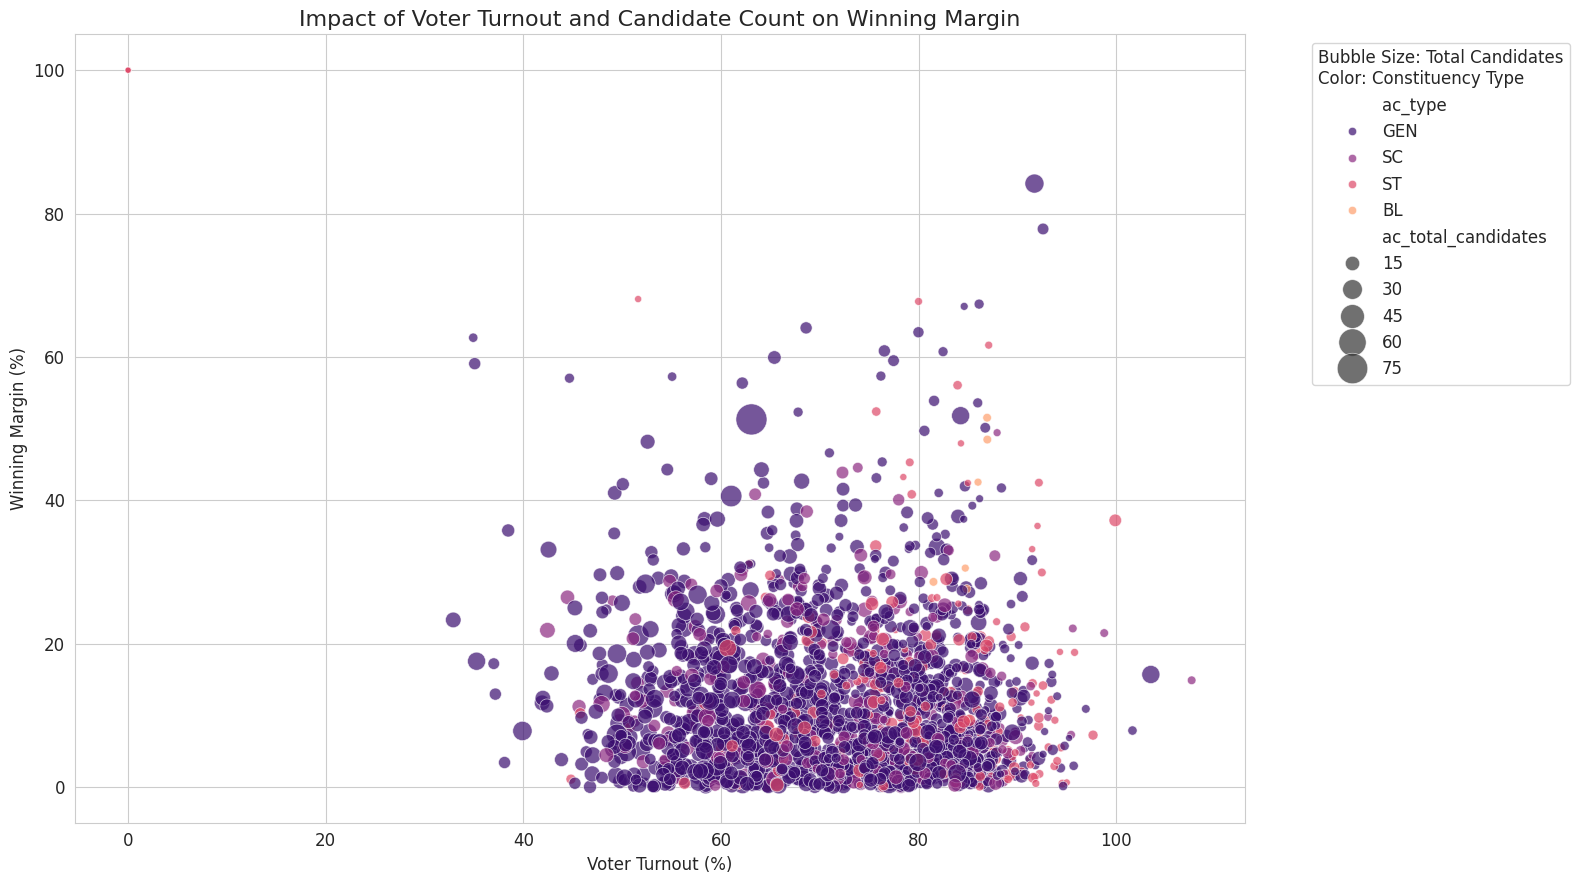

➡️ Conclusion: 💭 The relationship is complex, but the chart suggests that elections with a very high number of candidates (larger bubbles) do not necessarily result in smaller victory margins, indicating factors other than vote splitting are at play.


In [75]:
# Impact of Turnout and Candidate Count on Victory Margin
print("\n Analyzing the impact of turnout and candidate count on victory margins...")

# Use a sample of winners for clarity, as plotting all points can be dense
df_winners_sample = df_valid[df_valid['result'] == 1].sample(n=2000, random_state=42)

plt.figure(figsize=(16, 9))
sns.scatterplot(
    data=df_winners_sample,
    x='turnout_percentage',
    y='margin_percentage',
    size='ac_total_candidates',  # Bubble size represents the number of candidates
    hue='ac_type',              # Color represents the constituency type
    sizes=(20, 500),            # Range of bubble sizes
    alpha=0.7,
    palette='magma'
)

plt.title('Impact of Voter Turnout and Candidate Count on Winning Margin', fontsize=16)
plt.xlabel('Voter Turnout (%)', fontsize=12)
plt.ylabel('Winning Margin (%)', fontsize=12)
plt.legend(title='Bubble Size: Total Candidates\nColor: Constituency Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, '12_2_turnout_candidates_margin_bubble.png'), dpi=300, bbox_inches='tight')
plt.show()

print("➡️ Conclusion: 💭 The relationship is complex, but the chart suggests that elections with a very high number of candidates (larger bubbles) do not necessarily result in smaller victory margins, indicating factors other than vote splitting are at play.")

# Age vs. Vote Share by Gender within Top Parties



 Analyzing age vs. vote share by gender for top parties...


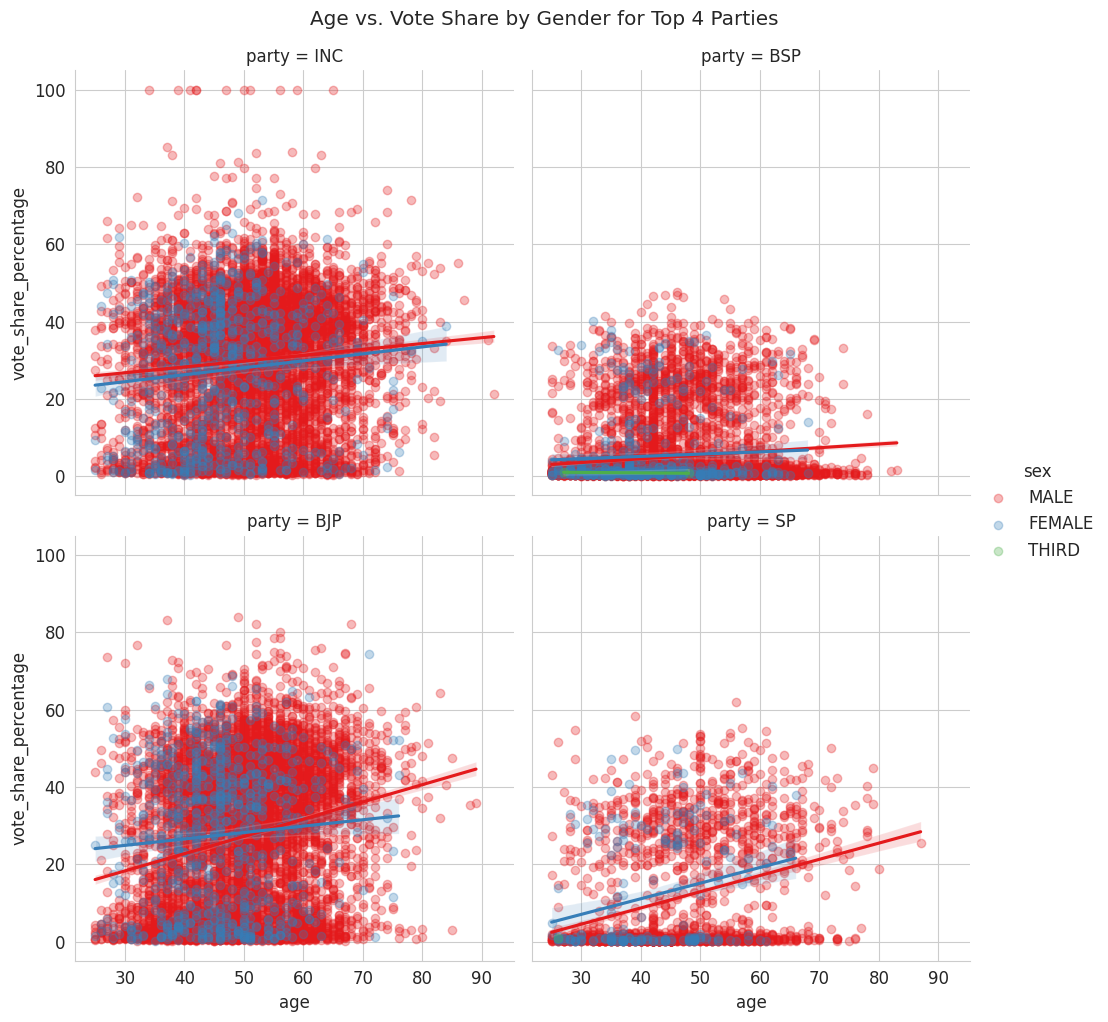

➡️ Conclusion: 🧐 Across major parties, there is no strong linear relationship between a candidate's age and their vote share. The performance patterns for male and female candidates within each party appear largely similar.


In [77]:
# Age vs. Vote Share by Gender within Top Parties
print("\n Analyzing age vs. vote share by gender for top parties...")

# Identify top 4 parties (excluding IND) for clearer faceting
top_4_parties = df_valid[df_valid['party'] != 'IND']['party'].value_counts().nlargest(4).index.tolist()
df_top_4_filtered = df_valid[df_valid['party'].isin(top_4_parties)]

# Use lmplot to create faceted scatter plots with regression lines
sns.lmplot(
    data=df_top_4_filtered,
    x='age',
    y='vote_share_percentage',
    hue='sex',
    col='party',          # Create separate columns for each party
    col_wrap=2,           # Wrap the columns into 2x2 grid
    palette='Set1',
    scatter_kws={'alpha': 0.3}
)

plt.suptitle('Age vs. Vote Share by Gender for Top 4 Parties', y=1.02)
plt.savefig(os.path.join(output_dir, '12_3_age_voteshare_gender_party_facet.png'), dpi=300, bbox_inches='tight')
plt.show()

print("➡️ Conclusion: 🧐 Across major parties, there is no strong linear relationship between a candidate's age and their vote share. The performance patterns for male and female candidates within each party appear largely similar.")

#Project Conclusion & Key Insights
This extensive exploratory data analysis of the Indian Assembly Elections dataset has illuminated several key trends and characteristics of the nation's state-level democratic processes. By cleaning, mapping, and visualizing the data from multiple perspectives—univariate, bivariate, multivariate, and geospatial—we have extracted the following critical insights:

#1. The Electoral Landscape: High Participation & Significant Gender Disparity

Massive Participation: The sheer volume of candidates contesting elections, particularly peaking in 2012, underscores the vibrant and active nature of India's state-level democracy. Districts within populous states and metropolitan areas, such as North 24 Parganas, serve as epicenters of political activity, hosting the highest number of candidates.

Overwhelming Gender Imbalance: The most striking demographic insight is the profound gender disparity. Over 93% of all candidates are male, revealing a significant structural barrier to female participation in electoral politics. While some larger states like Uttar Pradesh and West Bengal elect a higher absolute number of female candidates, their proportional representation remains extremely low across the board.

#2. Candidate & Party Dynamics: Age, Independents, and Strike Rates

Experienced Candidates Dominate: The age distribution of candidates is centered in the late 40s and early 50s, with a mean age of approximately 47. This indicates that political candidacy is generally pursued by individuals with considerable life and professional experience. The age profiles across major national parties are remarkably similar, suggesting a common archetype for political aspirants.

The Paradox of Independent Candidates: While Independent candidates (IND) form the single largest group by participation, their electoral success is exceptionally low, with a win rate of less than 1%. The vast majority of independents fail to secure a significant vote share, highlighting the immense challenge of winning without the backing of an established party structure.

High Strike Rates of Regional Powers: When analyzing the win percentage (strike rate) of parties that field a significant number of candidates, it's the dominant regional parties—such as AITC in West Bengal and DMK in Tamil Nadu—that demonstrate the highest efficiency in converting contests into wins. This underscores their deep-rooted influence within their respective states.

#3. Electoral Competitiveness & Voter Engagement

Consistent Voter Turnout: Voter turnout across constituencies is generally high and consistent, with a median turnout of over 75%. This points to a robust and engaged electorate at the state level.

A Mix of Close Contests and Landslides: The analysis of victory margins reveals a dual-natured electoral environment. A significant number of seats are won by comfortable margins of over 20%, indicating strongholds and decisive victories. However, a notable portion of elections are fiercely competitive, with nearly 1 in 10 seats being won by a slim margin of less than 5%.

#4. State-Level & Geospatial Political Strongholds

Dynamic State Politics: The state-wise seat retention analysis paints a picture of a fluid political landscape. In each election cycle, major parties are both "retaining" a core base of seats and "grabbing" a significant number from their rivals, highlighting the competitive nature of state politics. The analysis correctly identifies the dominant players in each state, such as the SP-BSP-BJP dynamic in Uttar Pradesh.

Geospatial Concentration of Power: The choropleth map provides a powerful visual confirmation of party strongholds. For instance, the BJP's electoral success is heavily concentrated in the Hindi heartland states of Northern, Western, and Central India, illustrating the geographic patterns of its political influence.

In summary, this project successfully transformed a raw, complex dataset into a series of clear, actionable insights. It reveals an electoral system characterized by high participation but significant gender inequality, dominated by experienced candidates and established parties. While national parties have a broad footprint, regional parties often exhibit superior electoral efficiency. The political landscape remains dynamic and competitive, with clear geographical and state-level patterns of party dominance.

In [9]:
import pandas as pd
import plotly.graph_objects as go
import warnings

# Suppress warnings for cleaner output
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

print("--- Starting DETAILED Party-to-Party Transition Analysis (No Independents) ---")
print("This script will load 'cleaned_election_data.csv', filter out 'IND',")
print("perform all calculations in memory, and generate detailed, attractive Sankey plots.")

# --- 1. Load Data ---
try:
    # Using the exact file path you provided
    df = pd.read_csv(r"C:\Users\DELL\Downloads\cleaned_election_data.csv", usecols=['year', 'state_name', 'candidate_name', 'party'])
except FileNotFoundError:
    print("Error: 'cleaned_election_data.csv' not found at C:\\Users\\DELL\\Downloads\\")
    print("Please ensure the file is in that exact location.")
    df = None

if df is not None:
    print(f"Successfully loaded 'cleaned_election_data.csv'. Original rows: {len(df)}")
    
    # --- 2. Filter out Independents ('IND') ---
    df = df[df['party'] != 'IND'].copy()
    print(f"Removed Independents. Remaining rows: {len(df)}")

    # --- 3. Identify Top 5 Parties PER State (Excluding IND) ---
    print("Identifying Top 5 parties for each state (IND excluded)...")
    state_party_counts = df.groupby(['state_name', 'party']).size().reset_index(name='count')
    
    top_5_per_state = (
        state_party_counts.sort_values(by='count', ascending=False)
        .groupby('state_name')
        .head(5)
    )
    
    # Create a lookup DataFrame of (state_name, party) pairs
    top_5_pairs = top_5_per_state[['state_name', 'party']]
    print(f"Identified {len(top_5_pairs)} state-party pairs as 'Top 5'.")

    # --- 4. Find Candidate Transitions ---
    print("Processing candidate career histories...")
    df_sorted = df.sort_values(by=['state_name', 'candidate_name', 'year'])
    
    df_sorted['source_party'] = df_sorted['party']
    df_sorted['target_party'] = df_sorted.groupby(['state_name', 'candidate_name'])['party'].shift(-1)
    
    transitions = df_sorted.dropna(subset=['target_party'])
    
    # Filter out same-party movements
    transitions = transitions[transitions['source_party'] != transitions['target_party']]

    # --- 5. Aggregate All Transitions ---
    print("Aggregating all party-to-party transitions...")
    links = transitions.groupby(['state_name', 'source_party', 'target_party']).size().reset_index(name='value')
    
    # --- 6. Filter Links to Top 5 Parties (Source AND Target) ---
    print("Filtering transitions to only those *between* the Top 5 parties in each state...")

    # Merge to keep only rows where the SOURCE party is in the Top 5 for that state
    links_top5 = pd.merge(
        links,
        top_5_pairs,
        left_on=['state_name', 'source_party'],
        right_on=['state_name', 'party'],
        how='inner'
    )
    
    # Merge again to keep only rows where the TARGET party is *also* in the Top 5
    links_top5 = pd.merge(
        links_top5,
        top_5_pairs,
        left_on=['state_name', 'target_party'],
        right_on=['state_name', 'party'],
        how='inner'
    )
    
    # Clean up merged columns
    links_filtered = links_top5[['state_name', 'source_party', 'target_party', 'value']]
    print("In-memory transitions DataFrame is ready.")

    # --- 7. Define the NEW Enhanced Plotting Function ---
    def plot_transition_sankey_detailed(state, df_links_data):
        """
        Generates a detailed, attractive, and self-explanatory
        Sankey chart for party-to-party transitions.
        """
        print(f"\n--- Generating DETAILED plot for: {state} ---")
        
        # Filter for the specific state
        df_plot = df_links_data[df_links_data['state_name'] == state].copy()
        
        if df_plot.empty:
            print(f"No Top 5-to-Top 5 transitions found for {state}.")
            return

        # --- Define Nodes and Links ---
        all_nodes = pd.concat([df_plot['source_party'], df_plot['target_party']]).unique()
        node_map = {label: i for i, label in enumerate(all_nodes)}
        
        # --- Create Link Data ---
        source = df_plot['source_party'].map(node_map)
        target = df_plot['target_party'].map(node_map)
        value = df_plot['value']
        
        # --- Enhancements ---
        
        # 1. Define Colors for major parties
        party_colors = {
            'BJP': '#FF9933', # Orange
            'INC': '#19AAED', # Light Blue
            'SP': '#FF0000',  # Red
            'BSP': '#0000FF', # Blue
            'AITC': '#008000', # Green
            'CPM': '#CC0000', # Dark Red
            'TDP': '#FFFF00', # Yellow
            'DMK': '#000000', # Black
            'SHS': '#F28C28', # Saffron
            'NCP': '#00008B', # Dark Blue
        }
        
        # Assign colors to nodes, with a default grey
        node_colors = [party_colors.get(node, '#888888') for node in all_nodes]
        
        # 2. Define Link Colors (semi-transparent based on source)
        link_colors = []
        for party in df_plot['source_party']:
            color_hex = party_colors.get(party, '#888888') # Get hex
            # Convert hex to RGB
            r = int(color_hex[1:3], 16)
            g = int(color_hex[3:5], 16)
            b = int(color_hex[5:7], 16)
            link_colors.append(f'rgba({r}, {g}, {b}, 0.4)') # Add alpha
        
        # 3. Create Custom Hover Text for links
        link_hover_labels = [f"{row['source_party']} → {row['target_party']}: {row['value']} candidates" 
                             for _, row in df_plot.iterrows()]

        # --- Create the Plotly Figure ---
        fig = go.Figure(go.Sankey(
            arrangement="snap",
            node=dict(
                pad=25,              # Increased padding for clarity
                thickness=20,        # Standard thickness
                line=dict(color="black", width=0.5),
                label=all_nodes,     # Party names
                color=node_colors,   # Use custom party colors
                hovertemplate='Party: <b>%{label}</b><extra></extra>' # Simple hover for node
            ),
            link=dict(
                source=source,
                target=target,
                value=value,
                color=link_colors,    # Use semi-transparent source party color
                hovertemplate='<b>%{customdata}</b><extra></extra>', # Use custom hover text
                customdata=link_hover_labels # Pass the custom labels
            )
        ))

        fig.update_layout(
            title_text=f"<b>Candidate Party-Hopping Analysis: {state}</b><br><i>(Flow between Top 5 parties, 'IND' excluded)</i>",
            font_size=12,
            height=700, # Taller chart for better visibility
            font_family="Arial, sans-serif", # Clean font
        )
        
        print(f"Displaying plot for {state}...")
        fig.show()

    # --- 8. Generate the Plots for ALL States ---
    
    print("\n" + "="*50)
    print(" === GENERATING PLOTS FOR ALL STATES === ")
    print("="*50)
    
    # Get a list of all unique states that have transition data
    all_states_with_data = links_filtered['state_name'].unique()
    all_states_with_data.sort() # Sort them alphabetically
    
    print(f"Found {len(all_states_with_data)} states with Top 5-to-Top 5 transitions.")
    
    # Loop through each state and call the plotting function
    for state in all_states_with_data:
        plot_transition_sankey_detailed(state, links_filtered)

    print("\n" + "="*50)
    print(" === ALL STATE PLOTS GENERATED === ")
    print("="*50)

else:
    print("DataFrame not loaded. Aborting script.")

--- Starting DETAILED Party-to-Party Transition Analysis (No Independents) ---
This script will load 'cleaned_election_data.csv', filter out 'IND',
perform all calculations in memory, and generate detailed, attractive Sankey plots.
Successfully loaded 'cleaned_election_data.csv'. Original rows: 115854
Removed Independents. Remaining rows: 73397
Identifying Top 5 parties for each state (IND excluded)...
Identified 159 state-party pairs as 'Top 5'.
Processing candidate career histories...
Aggregating all party-to-party transitions...
Filtering transitions to only those *between* the Top 5 parties in each state...
In-memory transitions DataFrame is ready.

 === GENERATING PLOTS FOR ALL STATES === 
Found 31 states with Top 5-to-Top 5 transitions.

--- Generating DETAILED plot for: Andhra Pradesh ---
Displaying plot for Andhra Pradesh...



--- Generating DETAILED plot for: Arunachal Pradesh ---
Displaying plot for Arunachal Pradesh...



--- Generating DETAILED plot for: Assam ---
Displaying plot for Assam...



--- Generating DETAILED plot for: Bihar ---
Displaying plot for Bihar...



--- Generating DETAILED plot for: Chhattisgarh ---
Displaying plot for Chhattisgarh...



--- Generating DETAILED plot for: Delhi ---
Displaying plot for Delhi...



--- Generating DETAILED plot for: Goa ---
Displaying plot for Goa...



--- Generating DETAILED plot for: Gujarat ---
Displaying plot for Gujarat...



--- Generating DETAILED plot for: Haryana ---
Displaying plot for Haryana...



--- Generating DETAILED plot for: Himachal Pradesh ---
Displaying plot for Himachal Pradesh...



--- Generating DETAILED plot for: Jammu And Kashmir ---
Displaying plot for Jammu And Kashmir...



--- Generating DETAILED plot for: Jharkhand ---
Displaying plot for Jharkhand...



--- Generating DETAILED plot for: Karnataka ---
Displaying plot for Karnataka...



--- Generating DETAILED plot for: Kerala ---
Displaying plot for Kerala...



--- Generating DETAILED plot for: Madhya Pradesh ---
Displaying plot for Madhya Pradesh...



--- Generating DETAILED plot for: Maharashtra ---
Displaying plot for Maharashtra...



--- Generating DETAILED plot for: Manipur ---
Displaying plot for Manipur...



--- Generating DETAILED plot for: Meghalaya ---
Displaying plot for Meghalaya...



--- Generating DETAILED plot for: Mizoram ---
Displaying plot for Mizoram...



--- Generating DETAILED plot for: Nagaland ---
Displaying plot for Nagaland...



--- Generating DETAILED plot for: Odisha ---
Displaying plot for Odisha...



--- Generating DETAILED plot for: Puducherry ---
Displaying plot for Puducherry...



--- Generating DETAILED plot for: Punjab ---
Displaying plot for Punjab...



--- Generating DETAILED plot for: Rajasthan ---
Displaying plot for Rajasthan...



--- Generating DETAILED plot for: Sikkim ---
Displaying plot for Sikkim...



--- Generating DETAILED plot for: Tamil Nadu ---
Displaying plot for Tamil Nadu...



--- Generating DETAILED plot for: Telangana ---
Displaying plot for Telangana...



--- Generating DETAILED plot for: Tripura ---
Displaying plot for Tripura...



--- Generating DETAILED plot for: Uttar Pradesh ---
Displaying plot for Uttar Pradesh...



--- Generating DETAILED plot for: Uttarakhand ---
Displaying plot for Uttarakhand...



--- Generating DETAILED plot for: West Bengal ---
Displaying plot for West Bengal...



 === ALL STATE PLOTS GENERATED === 


In [10]:
import pandas as pd
import plotly.graph_objects as go
import warnings
import os  # <-- ADDED THIS IMPORT

print("--- Starting DETAILED Party-to-Party Transition Analysis (No Independents) ---")
print("This script will load 'cleaned_election_data.csv', filter out 'IND',")
print("perform all calculations in memory, and generate detailed, attractive Sankey plots.")

# --- 1. Load Data ---
try:
    df = pd.read_csv(r"C:\Users\DELL\Downloads\cleaned_election_data.csv", usecols=['year', 'state_name', 'candidate_name', 'party'])
except FileNotFoundError:
    print("Error: 'cleaned_election_data.csv' not found at C:\\Users\\DELL\\Downloads\\")
    print("Please ensure the file is in that exact location.")
    df = None

if df is not None:
    print(f"Successfully loaded 'cleaned_election_data.csv'. Original rows: {len(df)}")
    
    # --- 2. Filter out Independents ('IND') ---
    df = df[df['party'] != 'IND'].copy()
    print(f"Removed Independents. Remaining rows: {len(df)}")

    # --- 3. Identify Top 5 Parties PER State (Excluding IND) ---
    print("Identifying Top 5 parties for each state (IND excluded)...")
    state_party_counts = df.groupby(['state_name', 'party']).size().reset_index(name='count')
    
    top_5_per_state = (
        state_party_counts.sort_values(by='count', ascending=False)
        .groupby('state_name')
        .head(5)
    )
    
    top_5_pairs = top_5_per_state[['state_name', 'party']]
    print(f"Identified {len(top_5_pairs)} state-party pairs as 'Top 5'.")

    # --- 4. Find Candidate Transitions ---
    print("Processing candidate career histories...")
    df_sorted = df.sort_values(by=['state_name', 'candidate_name', 'year'])
    
    df_sorted['source_party'] = df_sorted['party']
    df_sorted['target_party'] = df_sorted.groupby(['state_name', 'candidate_name'])['party'].shift(-1)
    
    transitions = df_sorted.dropna(subset=['target_party'])
    transitions = transitions[transitions['source_party'] != transitions['target_party']]

    # --- 5. Aggregate All Transitions ---
    print("Aggregating all party-to-party transitions...")
    links = transitions.groupby(['state_name', 'source_party', 'target_party']).size().reset_index(name='value')
    
    # --- 6. Filter Links to Top 5 Parties (Source AND Target) ---
    print("Filtering transitions to only those *between* the Top 5 parties in each state...")
    links_top5 = pd.merge(links, top_5_pairs, left_on=['state_name', 'source_party'], right_on=['state_name', 'party'], how='inner')
    links_top5 = pd.merge(links_top5, top_5_pairs, left_on=['state_name', 'target_party'], right_on=['state_name', 'party'], how='inner')
    
    links_filtered = links_top5[['state_name', 'source_party', 'target_party', 'value']]
    print("In-memory transitions DataFrame is ready.")

    # --- 7. Define the NEW Enhanced Plotting Function ---
    def plot_transition_sankey_detailed(state, df_links_data, output_folder="."):
        """
        Generates a detailed, attractive, and self-explanatory
        Sankey chart and SAVES it to a file.
        """
        print(f"\n--- Generating DETAILED plot for: {state} ---")
        
        df_plot = df_links_data[df_links_data['state_name'] == state].copy()
        
        if df_plot.empty:
            print(f"No Top 5-to-Top 5 transitions found for {state}.")
            return

        # ... (Rest of the plotting logic is the same) ...
        
        all_nodes = pd.concat([df_plot['source_party'], df_plot['target_party']]).unique()
        node_map = {label: i for i, label in enumerate(all_nodes)}
        source = df_plot['source_party'].map(node_map)
        target = df_plot['target_party'].map(node_map)
        value = df_plot['value']
        
        party_colors = {
            'BJP': '#FF9933', 'INC': '#19AAED', 'SP': '#FF0000', 'BSP': '#0000FF',
            'AITC': '#008000', 'CPM': '#CC0000', 'TDP': '#FFFF00', 'DMK': '#000000',
            'SHS': '#F28C28', 'NCP': '#00008B',
        }
        node_colors = [party_colors.get(node, '#888888') for node in all_nodes]
        
        link_colors = []
        for party in df_plot['source_party']:
            color_hex = party_colors.get(party, '#888888')
            r = int(color_hex[1:3], 16)
            g = int(color_hex[3:5], 16)
            b = int(color_hex[5:7], 16)
            link_colors.append(f'rgba({r}, {g}, {b}, 0.4)')
        
        link_hover_labels = [f"{row['source_party']} → {row['target_party']}: {row['value']} candidates" 
                             for _, row in df_plot.iterrows()]

        fig = go.Figure(go.Sankey(
            arrangement="snap",
            node=dict(
                pad=25, thickness=20, line=dict(color="black", width=0.5),
                label=all_nodes, color=node_colors,
                hovertemplate='Party: <b>%{label}</b><extra></extra>'
            ),
            link=dict(
                source=source, target=target, value=value,
                color=link_colors,
                hovertemplate='<b>%{customdata}</b><extra></extra>',
                customdata=link_hover_labels
            )
        ))

        fig.update_layout(
            title_text=f"<b>Candidate Party-Hopping Analysis: {state}</b><br><i>(Flow between Top 5 parties, 'IND' excluded)</i>",
            font_size=12, height=700, font_family="Arial, sans-serif",
        )
        
        print(f"Displaying plot for {state}...")
        fig.show()
        
        # --- [NEW CODE] SAVE THE PLOT ---
        try:
            # Create a clean filename (e.g., "sankey_Uttar_Pradesh.png")
            clean_state_name = state.replace(" ", "_").replace("&", "and")
            file_name = f"sankey_{clean_state_name}.png"
            file_path = os.path.join(output_folder, file_name)
            
            # Save the figure
            fig.write_image(file_path, width=1200, height=700, scale=2)
            print(f"Successfully saved plot to: {file_path}")
            
        except Exception as e:
            print(f"Error saving image for {state}: {e}")
            print("Please ensure you have installed kaleido: pip install kaleido")
        # --- [END NEW CODE] ---

    # --- 8. Generate the Plots for ALL States ---
    
    print("\n" + "="*50)
    print(" === GENERATING AND SAVING PLOTS FOR ALL STATES === ")
    print("="*50)
    
    # Get a list of all unique states that have transition data
    all_states_with_data = links_filtered['state_name'].unique()
    all_states_with_data.sort() # Sort them alphabetically
    
    print(f"Found {len(all_states_with_data)} states with Top 5-to-Top 5 transitions.")
    
    # Loop through each state and call the plotting function
    for state in all_states_with_data:
        plot_transition_sankey_detailed(state, links_filtered)

    print("\n" + "="*50)
    print(" === ALL STATE PLOTS GENERATED AND SAVED === ")
    print("="*50)

else:
    print("DataFrame not loaded. Aborting script.")

--- Starting DETAILED Party-to-Party Transition Analysis (No Independents) ---
This script will load 'cleaned_election_data.csv', filter out 'IND',
perform all calculations in memory, and generate detailed, attractive Sankey plots.
Successfully loaded 'cleaned_election_data.csv'. Original rows: 115854
Removed Independents. Remaining rows: 73397
Identifying Top 5 parties for each state (IND excluded)...
Identified 159 state-party pairs as 'Top 5'.
Processing candidate career histories...
Aggregating all party-to-party transitions...
Filtering transitions to only those *between* the Top 5 parties in each state...
In-memory transitions DataFrame is ready.

 === GENERATING AND SAVING PLOTS FOR ALL STATES === 
Found 31 states with Top 5-to-Top 5 transitions.

--- Generating DETAILED plot for: Andhra Pradesh ---
Displaying plot for Andhra Pradesh...


Error saving image for Andhra Pradesh: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido

Please ensure you have installed kaleido: pip install kaleido

--- Generating DETAILED plot for: Arunachal Pradesh ---
Displaying plot for Arunachal Pradesh...


Error saving image for Arunachal Pradesh: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido

Please ensure you have installed kaleido: pip install kaleido

--- Generating DETAILED plot for: Assam ---
Displaying plot for Assam...


Error saving image for Assam: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido

Please ensure you have installed kaleido: pip install kaleido

--- Generating DETAILED plot for: Bihar ---
Displaying plot for Bihar...


Error saving image for Bihar: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido

Please ensure you have installed kaleido: pip install kaleido

--- Generating DETAILED plot for: Chhattisgarh ---
Displaying plot for Chhattisgarh...


Error saving image for Chhattisgarh: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido

Please ensure you have installed kaleido: pip install kaleido

--- Generating DETAILED plot for: Delhi ---
Displaying plot for Delhi...


Error saving image for Delhi: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido

Please ensure you have installed kaleido: pip install kaleido

--- Generating DETAILED plot for: Goa ---
Displaying plot for Goa...


Error saving image for Goa: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido

Please ensure you have installed kaleido: pip install kaleido

--- Generating DETAILED plot for: Gujarat ---
Displaying plot for Gujarat...


Error saving image for Gujarat: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido

Please ensure you have installed kaleido: pip install kaleido

--- Generating DETAILED plot for: Haryana ---
Displaying plot for Haryana...


Error saving image for Haryana: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido

Please ensure you have installed kaleido: pip install kaleido

--- Generating DETAILED plot for: Himachal Pradesh ---
Displaying plot for Himachal Pradesh...


Error saving image for Himachal Pradesh: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido

Please ensure you have installed kaleido: pip install kaleido

--- Generating DETAILED plot for: Jammu And Kashmir ---
Displaying plot for Jammu And Kashmir...


Error saving image for Jammu And Kashmir: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido

Please ensure you have installed kaleido: pip install kaleido

--- Generating DETAILED plot for: Jharkhand ---
Displaying plot for Jharkhand...


Error saving image for Jharkhand: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido

Please ensure you have installed kaleido: pip install kaleido

--- Generating DETAILED plot for: Karnataka ---
Displaying plot for Karnataka...


Error saving image for Karnataka: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido

Please ensure you have installed kaleido: pip install kaleido

--- Generating DETAILED plot for: Kerala ---
Displaying plot for Kerala...


Error saving image for Kerala: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido

Please ensure you have installed kaleido: pip install kaleido

--- Generating DETAILED plot for: Madhya Pradesh ---
Displaying plot for Madhya Pradesh...


Error saving image for Madhya Pradesh: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido

Please ensure you have installed kaleido: pip install kaleido

--- Generating DETAILED plot for: Maharashtra ---
Displaying plot for Maharashtra...


Error saving image for Maharashtra: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido

Please ensure you have installed kaleido: pip install kaleido

--- Generating DETAILED plot for: Manipur ---
Displaying plot for Manipur...


Error saving image for Manipur: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido

Please ensure you have installed kaleido: pip install kaleido

--- Generating DETAILED plot for: Meghalaya ---
Displaying plot for Meghalaya...


Error saving image for Meghalaya: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido

Please ensure you have installed kaleido: pip install kaleido

--- Generating DETAILED plot for: Mizoram ---
Displaying plot for Mizoram...


Error saving image for Mizoram: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido

Please ensure you have installed kaleido: pip install kaleido

--- Generating DETAILED plot for: Nagaland ---
Displaying plot for Nagaland...


Error saving image for Nagaland: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido

Please ensure you have installed kaleido: pip install kaleido

--- Generating DETAILED plot for: Odisha ---
Displaying plot for Odisha...


Error saving image for Odisha: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido

Please ensure you have installed kaleido: pip install kaleido

--- Generating DETAILED plot for: Puducherry ---
Displaying plot for Puducherry...


Error saving image for Puducherry: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido

Please ensure you have installed kaleido: pip install kaleido

--- Generating DETAILED plot for: Punjab ---
Displaying plot for Punjab...


Error saving image for Punjab: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido

Please ensure you have installed kaleido: pip install kaleido

--- Generating DETAILED plot for: Rajasthan ---
Displaying plot for Rajasthan...


Error saving image for Rajasthan: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido

Please ensure you have installed kaleido: pip install kaleido

--- Generating DETAILED plot for: Sikkim ---
Displaying plot for Sikkim...


Error saving image for Sikkim: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido

Please ensure you have installed kaleido: pip install kaleido

--- Generating DETAILED plot for: Tamil Nadu ---
Displaying plot for Tamil Nadu...


Error saving image for Tamil Nadu: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido

Please ensure you have installed kaleido: pip install kaleido

--- Generating DETAILED plot for: Telangana ---
Displaying plot for Telangana...


Error saving image for Telangana: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido

Please ensure you have installed kaleido: pip install kaleido

--- Generating DETAILED plot for: Tripura ---
Displaying plot for Tripura...


Error saving image for Tripura: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido

Please ensure you have installed kaleido: pip install kaleido

--- Generating DETAILED plot for: Uttar Pradesh ---
Displaying plot for Uttar Pradesh...


Error saving image for Uttar Pradesh: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido

Please ensure you have installed kaleido: pip install kaleido

--- Generating DETAILED plot for: Uttarakhand ---
Displaying plot for Uttarakhand...


Error saving image for Uttarakhand: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido

Please ensure you have installed kaleido: pip install kaleido

--- Generating DETAILED plot for: West Bengal ---
Displaying plot for West Bengal...


Error saving image for West Bengal: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido

Please ensure you have installed kaleido: pip install kaleido

 === ALL STATE PLOTS GENERATED AND SAVED === 


In [5]:
pip install --upgrade kaleido


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
